# SegFormer Train

In [ ]:
!nvidia-smi

Thu Sep  8 22:12:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
!cp /content/drive/MyDrive/Kaggle/netrc ~/.netrc

In [ ]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aruaru0. Use `wandb login --relogin` to force relogin


True

## kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/datas/kaggle.json  ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c hubmap-organ-segmentation

100% 5.76G/5.78G [00:31<00:00, 254MB/s]
100% 5.78G/5.78G [00:31<00:00, 198MB/s]


In [ ]:
# !mkdir hubmap
!unzip /content/hubmap-organ-segmentation.zip -d hubmap >/dev/null

In [ ]:
!pip install pytorch-lightning
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 5.0 MB/s 
     |████████████████████████████████| 419 kB 60.2 MB/s 
     |████████████████████████████████| 5.9 MB 59.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.1 MB/s 
     |████████████████████████████████| 365 kB 69.6 MB/s 
     |████████████████████████████████| 

In [ ]:
!pip install staintools
!pip install spams

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for staintools: filename=staintools-2.1.2-py3-none-any.whl size=14075 sha256=c8841d5db4156b54afac32f0bc357dc5c73e1d916c8d95dbdcca645099e0c00f
  Stored in directory: /root/.cache/pip/wheels/9b/ed/74/9d36d40854e911d8e2d2d28d7b67e37e9f176f913ecf34f813
Successfully built staintools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for spams: filename=spams-2.6.5.4-cp37-cp37m-linux_x86_64.whl size=3236600 sha256=a9b40fd43d1ddc61d6525cc1e20b11d765854cb5e4991fe4800faaff5190ebad
  Stored in directory: /root/.cache/pip/wheels/5e/92/17/e718e0e26bfcdd7e81afcf874ac2bc599dd7dd7f3ad78f9d76
Successfully built spams


In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()

## Start code

In [ ]:
import wandb
wandb.init(project="HuBMAP-SegFormer")

best dice,▁▄▄▄▄▄▅▆▆▆▆█████████████████████████████
best epoch,▁▁▂▂▂▂▅▆▆▆▆█████████████████████████████
dice,▄▃▃▄▄▆▄█▃▇▄▁▄▄▅▄▃▃▄▃▄▄▄▄▂▂▄▄▃▆▂▂▅▄▂▃▃▆▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▅▄▄▃▄▂▄▁▅▃▃▂▂▂▂▃▂▁▁▁▂▂▂▂▃▂▃▃▂▃▂▂▂▃▂▂▂
valid_loss,▁▃▄▂▄▃▅▃▅▂▇▂▇▅▄█▅▅▅▅▄▆▆▄▆▇▃▇▆▃▅▅▄▄▆▄▅▃▄▃
best dice,0.34747
best epoch,138
dice,0.22124
epoch,499


In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
from typing import Optional, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ConstantLR, LinearLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# from timm import create_model

import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import albumentations as albu
import random

import pandas as pd

from tqdm.notebook import tqdm

from sklearn.model_selection import KFold

In [ ]:
#https://www.kaggle.com/code/pestipeti/decoding-rle-masks/notebook
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle2mask(mask_rle, shape=(3000,3000)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

##  load test data

In [ ]:
SEED = 2022 #43
BATCH_SIZE = 4
Gradient_Accumulation_Step = 2

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

### FOLD

In [ ]:
DATA_DIR = './hubmap'
NFOLD = 5
FOLD = 4

WIDTH, HEIGHT = 512,512

model_path = '/content/drive/MyDrive/datas/HuBMAP/lung-model-b5-fold{}.pth'.format(FOLD)
MODEL_NAME = "nvidia/mit-b5"
# MODEL_NAME = "nvidia/segformer-b3-finetuned-ade-512-512"

wandb.SEED = SEED
wandb.config.NFOLD = NFOLD
wandb.config.FOLD = FOLD
wandb.config.WIDTH = WIDTH
wandb.config.HEIGHT= HEIGHT
wandb.config.MODEL_NAME = MODEL_NAME

#
# nvidia/segformer-b0-finetuned-ade-512-512
# nvidia/segformer-b1-finetuned-ade-512-512
# nvidia/segformer-b2-finetuned-ade-512-512
# nvidia/segformer-b3-finetuned-ade-512-512
# nvidia/segformer-b4-finetuned-ade-512-512
# nvidia/segformer-b5-finetuned-ade-640-640
# https://huggingface.co/models?other=segformer&sort=downloads&search=nvidia%2Fsegformer+finetuned
#
df = pd.read_csv(DATA_DIR + '/train.csv')

# lung only

In [ ]:
df = df[df['organ']=='lung'].reset_index()
df

,index,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
1,13,11064,lung,HPA,3000,3000,0.4,4,2210040 68 2213039 70 2216036 74 2219032 79 22...,65.0,Male
2,18,11629,lung,HPA,3000,3000,0.4,4,4143554 1 4146554 2 4149554 3 4152555 3 415555...,43.0,Female
3,26,1220,lung,HPA,3000,3000,0.4,4,1429797 16 1432793 21 1435791 23 1438789 27 14...,59.0,Male
4,30,12452,lung,HPA,3000,3000,0.4,4,4648688 22 4651675 37 4654675 39 4657670 48 46...,78.0,Male
5,33,12476,lung,HPA,3000,3000,0.4,4,2783561 23 2786559 26 2789558 28 2792556 31 27...,21.0,Male
6,35,127,lung,HPA,3000,3000,0.4,4,4237495 6 4240494 9 4243491 14 4246490 17 4249...,21.0,Male
7,37,12827,lung,HPA,3000,3000,0.4,4,3210652 9 3213650 16 3216647 21 3219645 24 322...,57.0,Female
8,39,13189,lung,HPA,3000,3000,0.4,4,1844328 7 1847327 10 1850270 27 1850326 13 185...,21.0,Male
9,46,14388,lung,HPA,3000,3000,0.4,4,2059356 15 2062356 16 2065352 25 2068350 29 20...,78.0,Male


In [ ]:
# class2idx = dict([(name,i+1) for i, name in enumerate(df.organ.unique())])
# class2idx['none'] = 0
# idx2class = dict([(class2idx[name], name) for name in class2idx])

class2idx = {'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0}
idx2class = {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'}

class2idx, idx2class

({'prostate': 1,
  'spleen': 2,
  'lung': 3,
  'kidney': 4,
  'largeintestine': 5,
  'none': 0},
 {1: 'prostate',
  2: 'spleen',
  3: 'lung',
  4: 'kidney',
  5: 'largeintestine',
  0: 'none'})

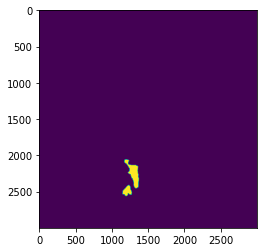

In [ ]:
idx = 0
height, width, rle = df['img_height'][idx], df['img_width'][idx], df['rle'][idx]
mask = rle2mask(rle, shape=(height, width))
plt.imshow(mask)

In [ ]:
from sklearn.model_selection import StratifiedKFold

df['fold'] = 0

skf = StratifiedKFold(n_splits=5)
for i, index in enumerate(skf.split(df.id, df.organ)):
  train_index, test_index = index
  # print("train_index:", train_index, "test_index:", test_index)
  # df['fold'][test_index] = i
  df.loc[test_index, 'fold'] = i

df

,index,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0
1,13,11064,lung,HPA,3000,3000,0.4,4,2210040 68 2213039 70 2216036 74 2219032 79 22...,65.0,Male,0
2,18,11629,lung,HPA,3000,3000,0.4,4,4143554 1 4146554 2 4149554 3 4152555 3 415555...,43.0,Female,0
3,26,1220,lung,HPA,3000,3000,0.4,4,1429797 16 1432793 21 1435791 23 1438789 27 14...,59.0,Male,0
4,30,12452,lung,HPA,3000,3000,0.4,4,4648688 22 4651675 37 4654675 39 4657670 48 46...,78.0,Male,0
5,33,12476,lung,HPA,3000,3000,0.4,4,2783561 23 2786559 26 2789558 28 2792556 31 27...,21.0,Male,0
6,35,127,lung,HPA,3000,3000,0.4,4,4237495 6 4240494 9 4243491 14 4246490 17 4249...,21.0,Male,0
7,37,12827,lung,HPA,3000,3000,0.4,4,3210652 9 3213650 16 3216647 21 3219645 24 322...,57.0,Female,0
8,39,13189,lung,HPA,3000,3000,0.4,4,1844328 7 1847327 10 1850270 27 1850326 13 185...,21.0,Male,0
9,46,14388,lung,HPA,3000,3000,0.4,4,2059356 15 2062356 16 2065352 25 2068350 29 20...,78.0,Male,0


## Utils

### augumentation

In [ ]:
import staintools

In [ ]:
class Stain(albu.ImageOnlyTransform):
    def __init__(
        self,
        method='vahadane', sigma1=0.2, sigma2=0.2,
        always_apply=False,
        p=0.5,
    ):
        super(Stain, self).__init__(always_apply, p)
        self.method = method
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.augmentor = staintools.StainAugmentor(method=method, sigma1=sigma1, sigma2=sigma2)

    def apply(self, img, **params):
        self.augmentor.fit(img)
        return self.augmentor.pop().astype(int)

    def get_params(self):
        return {
        }

    def get_transform_init_args_names(self):
        return ("brightness_limit", "contrast_limit", "brightness_by_max")

In [ ]:
# ----- set0
def get_training_augmentation_set0(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)
# ---- set1
def get_training_augmentation_set1(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        # albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
        #                  border_mode=cv2.BORDER_REFLECT),
        albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.ChannelShuffle(p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
    ], p=p)


In [ ]:
def get_training_augmentation3(p=0.5):
    return albu.Compose([
        albu.Sequential([
          albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
          albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
        ], p=p),
        albu.HorizontalFlip(p=p),
        albu.VerticalFlip(p=p),
        albu.RandomRotate90(p=p),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
                         border_mode=cv2.BORDER_REFLECT),
        # albu.OneOf([
        #     albu.OpticalDistortion(p=1),
        #     albu.GridDistortion(p=1),
        #     albu.IAAPiecewiseAffine(p=1),
        # ], p=p),
        albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=p),
        albu.OneOf([
            # albu.CLAHE(clip_limit=2, p = 1),
            albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
            albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
        ], p=p),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
        # albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
    ], p=p)

# def get_training_augmentation3(p=0.5):
#     return albu.Compose([
#         albu.Sequential([
#           albu.RandomScale(scale_limit=(-0.8, 0.0), interpolation=cv2.INTER_LINEAR, p=1),
#           albu.Resize(HEIGHT, WIDTH, interpolation=cv2.INTER_LINEAR, p=1)
#         ], p=p),
#         albu.HorizontalFlip(p=p),
#         albu.VerticalFlip(p=p),
#         albu.RandomRotate90(p=p),
#         albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=p, 
#                          border_mode=cv2.BORDER_REFLECT),
#         # albu.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=p, 
#         #                  border_mode=cv2.BORDER_REFLECT),
#         # albu.OneOf([
#         #     albu.OpticalDistortion(p=1),
#         #     albu.GridDistortion(p=1),
#         #     albu.IAAPiecewiseAffine(p=1),
#         # ], p=p),
#         albu.OneOf([
#             albu.ChannelShuffle(p=1),
#             albu.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=1),
#             albu.CLAHE(clip_limit=2, p = 1),
#             albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1),
#             albu.HueSaturationValue (hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
#         ], p=p),
#         albu.GaussNoise(var_limit=(10.0, 50.0), p=p),
#         albu.CoarseDropout (max_holes=50, max_height=16, max_width=16, p=p)
#     ], p=p)


In [ ]:
def get_training_augmentation2(p=1.0):
    return albu.Compose([
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.RandomRotate90(),
        albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        albu.OneOf([
            albu.OpticalDistortion(p=0.3),
            albu.GridDistortion(p=.1),
            albu.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        albu.OneOf([
            # albu.HueSaturationValue(10,15,10),
            albu.CLAHE(clip_limit=2),
            albu.RandomBrightnessContrast(),            
        ], p=0.3),
        albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3)
    ], p=p)

def get_training_augmentation():
    train_transform = [
        albu.PadIfNeeded(min_height=HEIGHT, min_width=WIDTH, always_apply=True, border_mode=0),
        albu.RandomCrop(height=HEIGHT, width=WIDTH, always_apply=True),
    ]
    return albu.Compose(train_transform)


def get_grayaug():
    train_transform = [
        albu.ToGray(p=1.0),
    ]
    return albu.Compose(train_transform)

# def get_validation_augmentation():
#     """画像のshapeが32で割り切れるようにPaddingするための関数"""
#     test_transform = [
#         albu.PadIfNeeded(384, 480)
#     ]
#     return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# 可視化用の関数
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## dataset

In [ ]:
from transformers import SegformerFeatureExtractor

mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))


# 1. torch.utils.data.Datasetを継承したDataset classを定義
class Dataset(torch.utils.data.Dataset):
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self,
            image_dir, 
            df, # ファイル名一覧
            # classes=None, # 推論対象のクラス
            augmentation=None, # augmentation用関数
            preprocessing=None, # 前処理用関数
            width = 768,
            height = 768,
    ):
        self.image_dir = image_dir
        self.df = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.width = width
        self.height = height
        self.feature_extractor = SegformerFeatureExtractor(MODEL_NAME , reduce_labels=False, size=(width, height))
    
    # 3. 学習用データ(image)と特徴(mask)を返す__getitem__メソッドを作成
    def __getitem__(self, i):
        # データの読み込み
        fname = "{}/{}.tiff".format(self.image_dir,self.df['id'][i])
        # print(fname)
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        rle, w, h = self.df['rle'][i], self.df['img_width'][i], self.df['img_height'][i]
        idx = class2idx[self.df['organ'][i]]
        mask = rle2mask(rle, shape = (w, h))
        # print(self.df['organ'][i], idx)

        image = cv2.resize(image, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height)) * idx

        # augmentation関数の適用
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # print("image", image.shape)
        # # return image, mask
        # image = (image/255 - mean)/std
        
        # return img2tensor(image),torch.tensor(mask), idx
        # return image, mask
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

    # 4. データセットの長さを返す__len__を作成
    def __len__(self):
        return len(self.df)

torch.Size([3, 512, 512])


tensor([0, 3])

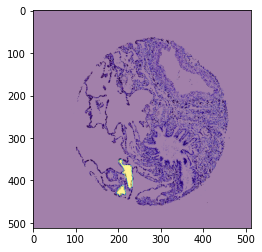

In [ ]:
IMAGE_DIR = './hubmap/train_images'
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), width=WIDTH, height=HEIGHT)
input = train_dataset[0]
print(input['pixel_values'].shape)
plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
plt.imshow(input['labels'], alpha=0.5)
input['labels'].unique()

In [ ]:
input

{'pixel_values': tensor([[[2.0263, 2.0092, 2.0263,  ..., 2.0434, 2.0605, 2.0605],
         [1.9749, 2.0263, 1.9920,  ..., 2.0263, 2.0777, 2.0605],
         [1.9920, 2.0092, 1.9749,  ..., 2.0092, 2.0605, 2.0605],
         ...,
         [2.0092, 2.0263, 2.0434,  ..., 2.0605, 2.0605, 2.0777],
         [1.9749, 1.9920, 2.0434,  ..., 2.0605, 2.0263, 2.0777],
         [1.9749, 2.0092, 2.0092,  ..., 2.0605, 2.0092, 2.0605]],

        [[2.1660, 2.2010, 2.1660,  ..., 2.2360, 2.2535, 2.2360],
         [2.1485, 2.1660, 2.2010,  ..., 2.2535, 2.2535, 2.2360],
         [2.2010, 2.1660, 2.1660,  ..., 2.1835, 2.2360, 2.2185],
         ...,
         [2.1660, 2.2185, 2.2010,  ..., 2.2360, 2.2535, 2.2360],
         [2.1660, 2.1310, 2.2185,  ..., 2.2360, 2.2535, 2.2535],
         [2.1485, 2.1660, 2.2360,  ..., 2.2360, 2.2185, 2.2360]],

        [[2.3611, 2.3786, 2.4308,  ..., 2.4134, 2.4134, 2.4308],
         [2.3960, 2.3786, 2.4308,  ..., 2.3960, 2.4308, 2.4308],
         [2.3786, 2.3611, 2.4134,  ..., 2

38
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])
0 torch.Size([3, 512, 512])


0 torch.Size([3, 512, 512])


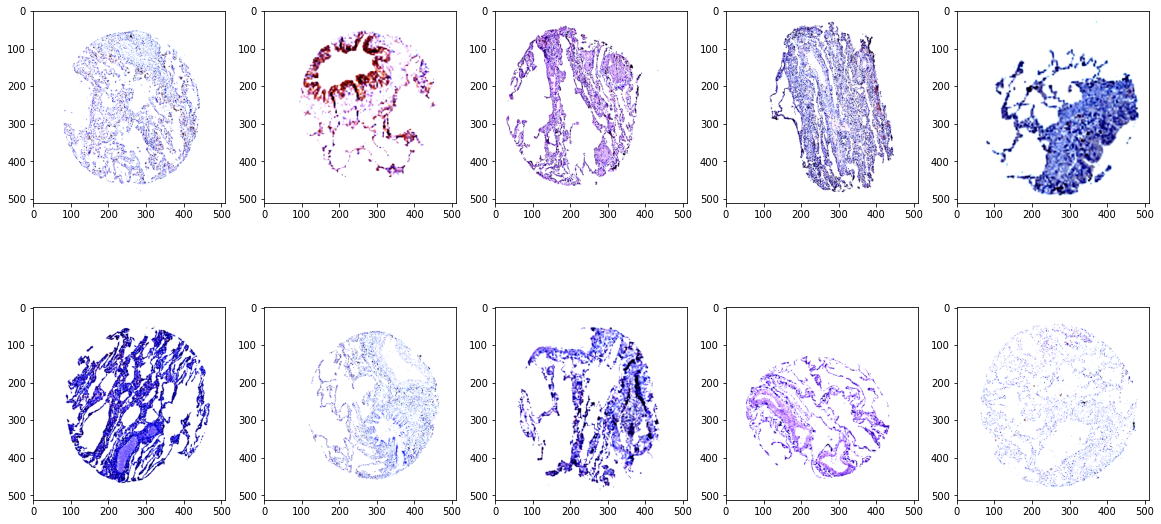

In [ ]:
# # # データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != 0].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(), 
                        )

plt.figure(figsize=(20, 10))

print(train_dataset.__len__())
for i in range(10) :
  input = train_dataset[i]
  print(idx, input.pixel_values.shape)
  plt.subplot(2, 5, i+1);
  plt.imshow(input['pixel_values'].permute(1,2,0).numpy())
  # plt.imshow(input['labels'], alpha=0.5)
plt.show()

In [ ]:
from torch.utils.data import DataLoader
# CLASSES = ['car']


# データセットのインスタンスを作成
train_dataset = Dataset(IMAGE_DIR, df[df['fold'] != FOLD].reset_index(), 
                        width=WIDTH, height=HEIGHT,
                        augmentation=get_training_augmentation3(p=0.9), 
                        )
# train_dataset = Dataset(IMAGE_DIR, df.reset_index(), 
#                         width=WIDTH, height=HEIGHT,
#                         augmentation=get_training_augmentation3(p=0.9), 
#                         )

valid_dataset = Dataset(
    IMAGE_DIR, df[df['fold'] == FOLD].reset_index(), 
    width=WIDTH, height=HEIGHT,
    augmentation=None, 
)

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

0


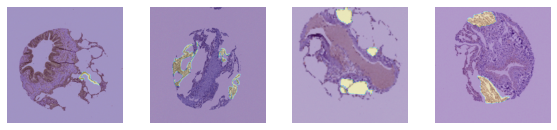

In [ ]:
row, col = 8, 8
plt.figure(figsize=(20,20))

for inputs in train_loader:
  print(idx)
  data = inputs['pixel_values']
  mask = inputs['labels']
  for i in range(BATCH_SIZE) :
    plt.subplot(col, row, i+1)
    x = data[i].permute(1,2,0)
    plt.imshow((x-x.min())/(x.max()-x.min()))
    plt.imshow(mask[i], alpha=0.3)
    plt.axis('off')
  # print(data.shape)
  break

## ここまで前処理

In [ ]:
from transformers import SegformerForSemanticSegmentation
# define model
model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                         num_labels=len(class2idx), 
                                                         id2label=idx2class, 
                                                         label2id=class2idx,
                                                         ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.0.proj.weight', 'deco

In [ ]:
# # model_path = '/content/drive/MyDrive/datas/HuBMAP/model.pth'
model_path_last = '/content/drive/MyDrive/datas/HuBMAP/last-fold{}.pth'.format(FOLD)

model.load_state_dict(torch.load(model_path_last))

<All keys matched successfully>

In [ ]:
from datasets import load_metric

metric = load_metric("mean_iou")

In [ ]:
test_df = df[df['fold'] == FOLD].reset_index()

def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice

def valid(model2) :
  model2.eval()
  dice = 0.0
  loss = 0.0
  for i in tqdm(range(len(test_df))) :
    id = test_df.id[i]
    fname = "/content/hubmap/train_images/{}.tiff".format(id)
    image = Image.open(fname)
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.cuda()

    # print(pixel_values.shape)

    organ = test_df.organ[i]
    idx = class2idx[organ]

    rle = test_df.rle[i]
    height, width = test_df.img_height[i], test_df.img_width[i]
    gt = rle2mask(rle, shape = (height, width))
    gt2 = cv2.resize(gt, pixel_values.shape[-2:]) * idx

    label = torch.tensor(gt2).unsqueeze(0).long().cuda()

    # print(label.shape)

    with torch.no_grad():
      outputs = model2(pixel_values=pixel_values, labels=label)
      loss += outputs.loss.item()
      # print(outputs.loss, loss)
      upsampled_logits = nn.functional.interpolate(outputs['logits'],
                  # size=image.size[::-1], # (height, width)
                  (height, width),
                  mode='bilinear',
                  align_corners=False)
      mask = upsampled_logits.argmax(dim=1)[0]
      mask[mask != idx] = 0
      mask[mask == idx] = 1


    dice += dice_coef(mask.cpu().numpy(), gt)
  return dice/len(test_df), loss/len(test_df)

In [ ]:
def read_model(file) :
  model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
                                                          num_labels=len(class2idx), 
                                                          id2label=idx2class, 
                                                          label2id=class2idx,
                                                          ignore_mismatched_sizes=True,
  )
  model.load_state_dict(torch.load(file))
  model.cuda()
  model.eval()
  return model

def copy_params(model1, model2) :
  model1.load_state_dict(model2.state_dict())
  return model1

def sum_model_params(modelA, modelB):
    """ modelA + modelB """
    sdA = modelA.state_dict()
    sdB = modelB.state_dict()
    for key in sdA:
        sdA[key] = (sdA[key] + sdB[key])
    modelA.load_state_dict(sdA)
    return modelA

def multi_model_params(model, a):
    """ a * model """
    sd = model.state_dict()
    for key in sd:
        sd[key] = sd[key] * a
    model.load_state_dict(sd)
    return model

In [ ]:
# import torch
# from torch import nn
# from sklearn.metrics import accuracy_score
# # from tqdm.notebook import tqdm
# # from tqdm import tqdm
# from fastprogress.fastprogress import  progress_bar as tqdm

# from PIL import Image
# from transformers import SegformerFeatureExtractor

# feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
# model = model.cuda()
# valid(model)

In [ ]:
# model_path_best = "/content/drive/MyDrive/datas/HuBMAP/merge-fold{}.pth".format(FOLD)
# model.load_state_dict(torch.load(model_path_best))

In [ ]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model = copy.deepcopy(model)
best_model.to(device)
best_model.eval()

tmp_model = copy.deepcopy(model).to(device).eval()

## TRAIN


In [75]:
import random

import torch
from torch import nn
from sklearn.metrics import accuracy_score
# from tqdm.notebook import tqdm
# from tqdm import tqdm
from fastprogress.fastprogress import  progress_bar as tqdm

from PIL import Image
from transformers import SegformerFeatureExtractor

writer = SummaryWriter(log_dir="./logs")
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))
use_amp = True # ampをオンオフ


# define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4,  weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.9)

# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 
#                                               base_lr=1e-5,
#                                               max_lr=1e-3,
#                                               step_size_up=20,
#                                               step_size_down=30,
#                                               mode="triangular2",
#                                               cycle_momentum=False,
#                                               gamma=0.95)


model.train()
print("best model")
cur_loss,_ = valid(best_model)
print("dice = ", cur_loss)
best_epoch = 0
for epoch in range(500):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   
   model.train()
   optimizer.zero_grad()

   tot_loss = 0.0
   for idx, batch in enumerate(tqdm(train_loader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # print(pixel_values.shape, labels.shape)

        # zero the parameter gradients
        with torch.cuda.amp.autocast(enabled=use_amp):
            # forward + backward + optimize
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss, logits = outputs.loss, outputs.logits

        tot_loss += loss.detach().cpu().numpy()
        
        scaler.scale(loss).backward()

        if (idx + 1) % Gradient_Accumulation_Step == 0 or idx == len(train_loader) :
            # optimizer.step()
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

   scheduler.step()

   print("Loss:", tot_loss/len(train_loader))

   print("valid...")

   dice,valid_loss = valid(model)

   writer.add_scalars("loss", {
       "train": tot_loss/len(train_loader),
       "valid": valid_loss,
       }, epoch+1)  
   writer.add_scalar("lr", scheduler.get_last_lr()[0], epoch+1)
   
   if dice > cur_loss :
     cur_loss = dice
     best_epoch = epoch
     print("update best dice = ", dice, "loss = ", valid_loss)
     torch.save(model.state_dict(), model_path)
     best_model = copy_params(best_model, model)
   elif random.random() >= 0.5:
     tmp_model = copy_params(tmp_model, best_model)
     tmp_model = sum_model_params(tmp_model, model)
     tmp_model = multi_model_params(tmp_model, 1/2)
     tmp_dice, tmp_valid_loss = valid(tmp_model)
     print("dice = ", dice , "tmp = ", tmp_dice, "best = ", cur_loss)
     if tmp_dice > cur_loss :
        cur_loss = tmp_dice
        best_epoch = epoch
        model = copy_params(model, tmp_model)
        best_model = copy_params(best_model, model)
        print("update best dice = ", tmp_dice, "loss = ", tmp_valid_loss, "best <- tmp_model")
        torch.save(model.state_dict(), model_path)  
     else:
       if tmp_dice > dice :
         model = copy_params(model, tmp_model)
         print("epoch dice = ", tmp_dice, "loss = ", tmp_valid_loss, "model <- tmp_model")
       else:
         print("epoch dice = ", dice, "loss = ", valid_loss)
   else :
         print("epoch dice = ", dice, "loss = ", valid_loss, "p<0.5")
         
   wandb.log({'epoch': epoch, 'train_loss': tot_loss/len(train_loader), "valid_loss": valid_loss, 
              "dice": dice, "lr":scheduler.get_last_lr()[0], "best dice": cur_loss, "best epoch": best_epoch})


writer.close()
wandb.save(model_path)

best model


dice =  0.052154154135446745
Epoch: 0


Loss: 0.07758588381111622
valid...


dice =  0.017424226893459703 tmp =  0.010641511608536741 best =  0.052154154135446745
epoch dice =  0.017424226893459703 loss =  0.07087198148171107
Epoch: 1


Loss: 0.08304484542459249
valid...


update best dice =  0.09603973837158142 loss =  0.07468950500090916
Epoch: 2


Loss: 0.06841578669846057
valid...


dice =  0.0 tmp =  0.0069536206621871105 best =  0.09603973837158142
epoch dice =  0.0069536206621871105 loss =  0.06759941246774462 model <- tmp_model
Epoch: 3


Loss: 0.059180510602891444
valid...


epoch dice =  0.01477545692190397 loss =  0.0642524351262384 p<0.5
Epoch: 4


Loss: 0.06162462644279003
valid...


epoch dice =  0.012007571840439817 loss =  0.06669873547636801 p<0.5
Epoch: 5


Loss: 0.06085289269685745
valid...


dice =  0.027240877354269093 tmp =  0.0303314603357479 best =  0.09603973837158142
epoch dice =  0.0303314603357479 loss =  0.06642188297377692 model <- tmp_model
Epoch: 6


Loss: 0.05714637711644173
valid...


epoch dice =  0.0 loss =  0.0724939571486579 p<0.5
Epoch: 7


Loss: 0.056742001324892044
valid...


epoch dice =  0.04424370250345283 loss =  0.07304854090842935 p<0.5
Epoch: 8


Loss: 0.05480276420712471
valid...


epoch dice =  0.03840960915825799 loss =  0.06698779761791229 p<0.5
Epoch: 9


Loss: 0.050624667480587957
valid...


dice =  0.0 tmp =  0.0 best =  0.09603973837158142
epoch dice =  0.0 loss =  0.0775887622601456
Epoch: 10


Loss: 0.04862216394394636
valid...


dice =  0.07949951425065305 tmp =  0.027335712564656098 best =  0.09603973837158142
epoch dice =  0.07949951425065305 loss =  0.07706867820686764
Epoch: 11


Loss: 0.05002534370869398
valid...


epoch dice =  0.024280861069774 loss =  0.0697637949552801 p<0.5
Epoch: 12


Loss: 0.05317157171666622
valid...


dice =  0.03632270823579245 tmp =  0.02694280128718691 best =  0.09603973837158142
epoch dice =  0.03632270823579245 loss =  0.07156356279220846
Epoch: 13


Loss: 0.045975275337696075
valid...


dice =  0.0040444715919231225 tmp =  0.0018811150492908857 best =  0.09603973837158142
epoch dice =  0.0040444715919231225 loss =  0.06743642211788231
Epoch: 14


Loss: 0.05440039187669754
valid...


dice =  0.015733865116061892 tmp =  0.02287765986811016 best =  0.09603973837158142
epoch dice =  0.02287765986811016 loss =  0.06379342679348257 model <- tmp_model
Epoch: 15


Loss: 0.046551381796598436
valid...


dice =  0.002391868534963628 tmp =  0.020766594604102306 best =  0.09603973837158142
epoch dice =  0.020766594604102306 loss =  0.06346907301081552 model <- tmp_model
Epoch: 16


Loss: 0.0522671215236187
valid...


dice =  0.0 tmp =  0.004242749825792539 best =  0.09603973837158142
epoch dice =  0.004242749825792539 loss =  0.067312008390824 model <- tmp_model
Epoch: 17


Loss: 0.055465812981128695
valid...


epoch dice =  0.0 loss =  0.0716567374765873 p<0.5
Epoch: 18


Loss: 0.05502743497490883
valid...


epoch dice =  0.06467659007698945 loss =  0.08199528604745865 p<0.5
Epoch: 19


Loss: 0.052525907009840014
valid...


dice =  0.015829972882916238 tmp =  0.017081400868871208 best =  0.09603973837158142
epoch dice =  0.017081400868871208 loss =  0.06510046165850428 model <- tmp_model
Epoch: 20


Loss: 0.05088599771261215
valid...


epoch dice =  0.005810752496168326 loss =  0.07492463621828291 p<0.5
Epoch: 21


Loss: 0.04875086434185505
valid...


dice =  0.035605857714507 tmp =  0.04602576805325182 best =  0.09603973837158142
epoch dice =  0.04602576805325182 loss =  0.06863413771821393 model <- tmp_model
Epoch: 22


Loss: 0.052811180055141446
valid...


dice =  0.0 tmp =  0.0 best =  0.09603973837158142
epoch dice =  0.0 loss =  0.07637039685828818
Epoch: 23


Loss: 0.05057045444846153
valid...


dice =  0.0812819728044334 tmp =  0.04601797605112291 best =  0.09603973837158142
epoch dice =  0.0812819728044334 loss =  0.07250348043938477
Epoch: 24


Loss: 0.04955858737230301
valid...


dice =  0.027096297906415562 tmp =  0.05343736139564895 best =  0.09603973837158142
epoch dice =  0.05343736139564895 loss =  0.06799239416917165 model <- tmp_model
Epoch: 25


Loss: 0.05244988054037094
valid...


dice =  0.0 tmp =  0.012411253423991929 best =  0.09603973837158142
epoch dice =  0.012411253423991929 loss =  0.06620559344689052 model <- tmp_model
Epoch: 26


Loss: 0.05247010849416256
valid...


dice =  0.0 tmp =  0.057322745061329505 best =  0.09603973837158142
epoch dice =  0.057322745061329505 loss =  0.06386230140924454 model <- tmp_model
Epoch: 27


Loss: 0.05949675142765045
valid...


epoch dice =  0.02503659108335474 loss =  0.0724433312813441 p<0.5
Epoch: 28


Loss: 0.05366399399936199
valid...


epoch dice =  0.015773817206618627 loss =  0.06998935445315307 p<0.5
Epoch: 29


Loss: 0.05536944903433323
valid...


update best dice =  0.10999547665759271 loss =  0.07237636856734753
Epoch: 30


Loss: 0.047531315870583055
valid...


dice =  0.014672496303472662 tmp =  0.041518458661775996 best =  0.10999547665759271
epoch dice =  0.041518458661775996 loss =  0.07114784667889278 model <- tmp_model
Epoch: 31


Loss: 0.0478090513497591
valid...


dice =  0.00797323410653235 tmp =  0.033652022952081966 best =  0.10999547665759271
epoch dice =  0.033652022952081966 loss =  0.06957139571507771 model <- tmp_model
Epoch: 32


Loss: 0.044495036639273164
valid...


dice =  0.0777014282404078 tmp =  0.07764325073769016 best =  0.10999547665759271
epoch dice =  0.0777014282404078 loss =  0.0733767884473006
Epoch: 33


Loss: 0.04788504764437675
valid...


dice =  0.04252302786626861 tmp =  0.06258386621219544 best =  0.10999547665759271
epoch dice =  0.06258386621219544 loss =  0.07100386565758122 model <- tmp_model
Epoch: 34


Loss: 0.044527298770844936
valid...


epoch dice =  0.0001965715741964457 loss =  0.07368585550122791 p<0.5
Epoch: 35


Loss: 0.051429548487067225
valid...


epoch dice =  0.06019849482608487 loss =  0.07091232368515597 p<0.5
Epoch: 36


Loss: 0.047454668954014775
valid...


epoch dice =  0.0980303553178072 loss =  0.0637155460814635 p<0.5
Epoch: 37


Loss: 0.04981742482632399
valid...


epoch dice =  0.08904840782350673 loss =  0.06911144281427066 p<0.5
Epoch: 38


Loss: 0.04300188645720482
valid...


epoch dice =  0.05831043465060489 loss =  0.07424793516596158 p<0.5
Epoch: 39


Loss: 0.04088436756283045
valid...


epoch dice =  0.05016810408816606 loss =  0.06905368239515358 p<0.5
Epoch: 40


Loss: 0.03877647258341312
valid...


epoch dice =  0.05293819756742002 loss =  0.08278212054736084 p<0.5
Epoch: 41


Loss: 0.042008121684193614
valid...


dice =  0.04588709877130617 tmp =  0.08987571920006862 best =  0.10999547665759271
epoch dice =  0.08987571920006862 loss =  0.06833196648706992 model <- tmp_model
Epoch: 42


Loss: 0.04286248814314604
valid...


epoch dice =  0.005805154868272892 loss =  0.06799909203416771 p<0.5
Epoch: 43


Loss: 0.04179518911987543
valid...


epoch dice =  0.049303744215335114 loss =  0.06751783575034803 p<0.5
Epoch: 44


Loss: 0.04059300385415554
valid...


epoch dice =  0.0235474398188001 loss =  0.07621408802353674 p<0.5
Epoch: 45


Loss: 0.03662135452032089
valid...


dice =  0.09767839939069278 tmp =  0.09542857479071248 best =  0.10999547665759271
epoch dice =  0.09767839939069278 loss =  0.06978615290588802
Epoch: 46


Loss: 0.03861132431775331
valid...


dice =  0.0046492242028947795 tmp =  0.056784960778633806 best =  0.10999547665759271
epoch dice =  0.056784960778633806 loss =  0.06809468753635883 model <- tmp_model
Epoch: 47


Loss: 0.04222682323306799
valid...


epoch dice =  0.04370395556239857 loss =  0.07280983610285653 p<0.5
Epoch: 48


Loss: 0.050642069429159164
valid...


dice =  0.07209944645115238 tmp =  0.09788243807566237 best =  0.10999547665759271
epoch dice =  0.09788243807566237 loss =  0.07122948641578357 model <- tmp_model
Epoch: 49


Loss: 0.04551273211836815
valid...


dice =  0.03411310936609105 tmp =  0.057483998139281685 best =  0.10999547665759271
epoch dice =  0.057483998139281685 loss =  0.07126670630855693 model <- tmp_model
Epoch: 50


Loss: 0.045471349358558656
valid...


dice =  0.0186771492397038 tmp =  0.05098476280938106 best =  0.10999547665759271
epoch dice =  0.05098476280938106 loss =  0.06887663021269771 model <- tmp_model
Epoch: 51


Loss: 0.0466920118778944
valid...


dice =  0.05674251084238321 tmp =  0.08812447975840834 best =  0.10999547665759271
epoch dice =  0.08812447975840834 loss =  0.06762625866880019 model <- tmp_model
Epoch: 52


Loss: 0.04314842373132706
valid...


epoch dice =  0.039342199878014676 loss =  0.06742014487584432 p<0.5
Epoch: 53


Loss: 0.047509536053985356
valid...


dice =  0.01868449789828671 tmp =  0.0507775412059194 best =  0.10999547665759271
epoch dice =  0.0507775412059194 loss =  0.07053104663888614 model <- tmp_model
Epoch: 54


Loss: 0.043732022307813166
valid...


dice =  0.05734619224489215 tmp =  0.08946995381579384 best =  0.10999547665759271
epoch dice =  0.08946995381579384 loss =  0.066183860724171 model <- tmp_model
Epoch: 55


Loss: 0.043831408582627775
valid...


dice =  0.02599641524297059 tmp =  0.05018805473118519 best =  0.10999547665759271
epoch dice =  0.05018805473118519 loss =  0.067996461979217 model <- tmp_model
Epoch: 56


Loss: 0.04504135642200709
valid...


epoch dice =  0.005772819236433451 loss =  0.07998047500020927 p<0.5
Epoch: 57


Loss: 0.04588747676461935
valid...


update best dice =  0.11695915964241745 loss =  0.06957151119907697
Epoch: 58


Loss: 0.04755674097687006
valid...


dice =  0.01537282282879999 tmp =  0.05999515362692948 best =  0.11695915964241745
epoch dice =  0.05999515362692948 loss =  0.06860505727430184 model <- tmp_model
Epoch: 59


Loss: 0.04450015295296907
valid...


epoch dice =  0.06545338375366495 loss =  0.07984140060014194 p<0.5
Epoch: 60


Loss: 0.04617283660918474
valid...


epoch dice =  0.02189046463855624 loss =  0.07232993096113205 p<0.5
Epoch: 61


Loss: 0.04431760814040899
valid...


epoch dice =  0.03363899073614757 loss =  0.07267513974673218 p<0.5
Epoch: 62


Loss: 0.04000732749700546
valid...


epoch dice =  0.0 loss =  0.08100038808253077 p<0.5
Epoch: 63


Loss: 0.04842323120683432
valid...


update best dice =  0.17682490498227596 loss =  0.08467909983462757
Epoch: 64


Loss: 0.04478710796684027
valid...


dice =  0.09251580750922522 tmp =  0.1413897593531229 best =  0.17682490498227596
epoch dice =  0.1413897593531229 loss =  0.07145639136433601 model <- tmp_model
Epoch: 65


Loss: 0.038940383866429326
valid...


dice =  0.09124575984535892 tmp =  0.12955033304944558 best =  0.17682490498227596
epoch dice =  0.12955033304944558 loss =  0.0739328083064821 model <- tmp_model
Epoch: 66


Loss: 0.04095437601208687
valid...


epoch dice =  0.09634363848799371 loss =  0.0754529032856226 p<0.5
Epoch: 67


Loss: 0.039189327880740164
valid...


dice =  0.08379043310445887 tmp =  0.14734568263680695 best =  0.17682490498227596
epoch dice =  0.14734568263680695 loss =  0.07385571176807086 model <- tmp_model
Epoch: 68


Loss: 0.038357256632298234
valid...


epoch dice =  0.03713070506018935 loss =  0.0660188411258989 p<0.5
Epoch: 69


Loss: 0.03823531325906515
valid...


dice =  0.09485958883882531 tmp =  0.1533085489619675 best =  0.17682490498227596
epoch dice =  0.1533085489619675 loss =  0.06956435905562507 model <- tmp_model
Epoch: 70


Loss: 0.03742757961153984
valid...


epoch dice =  0.008580673996702051 loss =  0.07454198743734095 p<0.5
Epoch: 71


Loss: 0.035585041902959344
valid...


epoch dice =  0.09508418855198203 loss =  0.0671664835471246 p<0.5
Epoch: 72


Loss: 0.03907583225518465
valid...


dice =  0.04443796687447604 tmp =  0.08780135659562935 best =  0.17682490498227596
epoch dice =  0.08780135659562935 loss =  0.06732635324199994 model <- tmp_model
Epoch: 73


Loss: 0.03534704893827438
valid...


epoch dice =  0.05472015008204879 loss =  0.06936611814631356 p<0.5
Epoch: 74


Loss: 0.0341085409745574
valid...


dice =  0.04398889325518554 tmp =  0.12591100543589318 best =  0.17682490498227596
epoch dice =  0.12591100543589318 loss =  0.06515395662022962 model <- tmp_model
Epoch: 75


Loss: 0.03358481992036104
valid...


dice =  0.08881007446899218 tmp =  0.15173674847390506 best =  0.17682490498227596
epoch dice =  0.15173674847390506 loss =  0.0694649683104621 model <- tmp_model
Epoch: 76


Loss: 0.03637051768600941
valid...


epoch dice =  0.09574873752353878 loss =  0.0682882218518191 p<0.5
Epoch: 77


Loss: 0.036241783015429976
valid...


epoch dice =  0.11923597086381658 loss =  0.07233537671466668 p<0.5
Epoch: 78


Loss: 0.03319287206977606
valid...


dice =  0.02674136103720855 tmp =  0.1274178841020979 best =  0.17682490498227596
epoch dice =  0.1274178841020979 loss =  0.0666973955101437 model <- tmp_model
Epoch: 79


Loss: 0.03486479464918375
valid...


dice =  0.07183158063117508 tmp =  0.15191889599564332 best =  0.17682490498227596
epoch dice =  0.15191889599564332 loss =  0.06969006690714094 model <- tmp_model
Epoch: 80


Loss: 0.036639615148305896
valid...


dice =  0.03967922884979491 tmp =  0.11708377852829074 best =  0.17682490498227596
epoch dice =  0.11708377852829074 loss =  0.06725227336088817 model <- tmp_model
Epoch: 81


Loss: 0.03741067675873637
valid...


dice =  0.07478105294890867 tmp =  0.10656788026353586 best =  0.17682490498227596
epoch dice =  0.10656788026353586 loss =  0.07094033600555526 model <- tmp_model
Epoch: 82


Loss: 0.03539492730051279
valid...


dice =  0.1254385884192494 tmp =  0.16181379227244008 best =  0.17682490498227596
epoch dice =  0.16181379227244008 loss =  0.06697196575502555 model <- tmp_model
Epoch: 83


Loss: 0.03801815174520016
valid...


epoch dice =  0.03799347767961308 loss =  0.06868320827682813 p<0.5
Epoch: 84


Loss: 0.039082384668290615
valid...


dice =  0.14910925826101173 tmp =  0.17440919295437116 best =  0.17682490498227596
epoch dice =  0.17440919295437116 loss =  0.07015932206478384 model <- tmp_model
Epoch: 85


Loss: 0.04042187463492155
valid...


epoch dice =  0.04369654304416432 loss =  0.0701474802982476 p<0.5
Epoch: 86


Loss: 0.03682191539555788
valid...


epoch dice =  0.0791216398409906 loss =  0.0760268575201432 p<0.5
Epoch: 87


Loss: 0.03434334322810173
valid...


dice =  0.03682810820674556 tmp =  0.11011606484875269 best =  0.17682490498227596
epoch dice =  0.11011606484875269 loss =  0.0666452364789115 model <- tmp_model
Epoch: 88


Loss: 0.04036972261965275
valid...


epoch dice =  0.09194663348888334 loss =  0.0669694859534502 p<0.5
Epoch: 89


Loss: 0.03540502823889256
valid...


dice =  0.05183079801752802 tmp =  0.12381195101851906 best =  0.17682490498227596
epoch dice =  0.12381195101851906 loss =  0.07047728014489014 model <- tmp_model
Epoch: 90


Loss: 0.03866767901927233
valid...


epoch dice =  0.02482268546992062 loss =  0.06934006863998042 p<0.5
Epoch: 91


Loss: 0.0362027445808053
valid...


epoch dice =  0.07091877431313123 loss =  0.07755280534426372 p<0.5
Epoch: 92


Loss: 0.032824152149260044
valid...


epoch dice =  0.01695583818329887 loss =  0.07484968058351013 p<0.5
Epoch: 93


Loss: 0.03310374449938536
valid...


epoch dice =  0.05999549092789068 loss =  0.07179924266205893 p<0.5
Epoch: 94


Loss: 0.03269249014556408
valid...


epoch dice =  0.046963927345702816 loss =  0.07067765730122726 p<0.5
Epoch: 95


Loss: 0.03481516372412443
valid...


dice =  0.14015104035247214 tmp =  0.17552643287967643 best =  0.17682490498227596
epoch dice =  0.17552643287967643 loss =  0.07318175211548805 model <- tmp_model
Epoch: 96


Loss: 0.037943710759282115
valid...


dice =  0.008928886983921948 tmp =  0.077261159553682 best =  0.17682490498227596
epoch dice =  0.077261159553682 loss =  0.06740752938720915 model <- tmp_model
Epoch: 97


Loss: 0.03840106762945652
valid...


dice =  0.015550656821629075 tmp =  0.09237405730333374 best =  0.17682490498227596
epoch dice =  0.09237405730333374 loss =  0.07167032236854236 model <- tmp_model
Epoch: 98


Loss: 0.03728094417601824
valid...


dice =  0.059119829722075426 tmp =  0.13993725726166792 best =  0.17682490498227596
epoch dice =  0.13993725726166792 loss =  0.0682664726757341 model <- tmp_model
Epoch: 99


Loss: 0.03957984074950218
valid...


epoch dice =  0.07551857375526866 loss =  0.06862493976950645 p<0.5
Epoch: 100


Loss: 0.03851971961557865
valid...


dice =  0.1428676324138183 tmp =  0.17591111391221217 best =  0.17682490498227596
epoch dice =  0.17591111391221217 loss =  0.07600700006716782 model <- tmp_model
Epoch: 101


Loss: 0.037557659484446046
valid...


dice =  0.06254776820419179 tmp =  0.14702218578960513 best =  0.17682490498227596
epoch dice =  0.14702218578960513 loss =  0.0692740384903219 model <- tmp_model
Epoch: 102


Loss: 0.03531406931579113
valid...


dice =  0.035321337084037736 tmp =  0.11311089837955923 best =  0.17682490498227596
epoch dice =  0.11311089837955923 loss =  0.06759610482388073 model <- tmp_model
Epoch: 103


Loss: 0.03542237542569637
valid...


dice =  0.056560498118008944 tmp =  0.12094065207054507 best =  0.17682490498227596
epoch dice =  0.12094065207054507 loss =  0.06806080953942405 model <- tmp_model
Epoch: 104


Loss: 0.0351709084585309
valid...


dice =  0.06571086015631089 tmp =  0.12199969799526864 best =  0.17682490498227596
epoch dice =  0.12199969799526864 loss =  0.06853518552250332 model <- tmp_model
Epoch: 105


Loss: 0.0366027532145381
valid...


epoch dice =  0.11884745562171606 loss =  0.06981180504792267 p<0.5
Epoch: 106


Loss: 0.038586909882724285
valid...


epoch dice =  0.09394794784657973 loss =  0.07178711560037401 p<0.5
Epoch: 107


Loss: 0.03820492029190063
valid...


epoch dice =  0.048677344272204465 loss =  0.0701351464829511 p<0.5
Epoch: 108


Loss: 0.041477973200380804
valid...


dice =  0.08449981925604938 tmp =  0.10929402724899236 best =  0.17682490498227596
epoch dice =  0.10929402724899236 loss =  0.07173991348180506 model <- tmp_model
Epoch: 109


Loss: 0.036598282121121886
valid...


dice =  0.06828955623177861 tmp =  0.12016953360933866 best =  0.17682490498227596
epoch dice =  0.12016953360933866 loss =  0.07007547260986434 model <- tmp_model
Epoch: 110


Loss: 0.036226725205779076
valid...


epoch dice =  0.027903139400726848 loss =  0.07187358941882849 p<0.5
Epoch: 111


Loss: 0.036593653820455076
valid...


dice =  0.0828734335458621 tmp =  0.11650078168644634 best =  0.17682490498227596
epoch dice =  0.11650078168644634 loss =  0.07256920615004168 model <- tmp_model
Epoch: 112


Loss: 0.037492869421839714
valid...


epoch dice =  0.026447376047264666 loss =  0.07039178783694904 p<0.5
Epoch: 113


Loss: 0.038638244941830636
valid...


epoch dice =  0.14686278414823367 loss =  0.07309835652510326 p<0.5
Epoch: 114


Loss: 0.0405576603487134
valid...


epoch dice =  0.007788251799321591 loss =  0.0762831134100755 p<0.5
Epoch: 115


Loss: 0.036078682728111745
valid...


dice =  0.07448011879063607 tmp =  0.1581615761095731 best =  0.17682490498227596
epoch dice =  0.1581615761095731 loss =  0.0712158963498142 model <- tmp_model
Epoch: 116


Loss: 0.034347712993621826
valid...


dice =  0.011791897742037004 tmp =  0.0930753792623405 best =  0.17682490498227596
epoch dice =  0.0930753792623405 loss =  0.06590423898564444 model <- tmp_model
Epoch: 117


Loss: 0.03855700064450503
valid...


dice =  0.10777562838344863 tmp =  0.1640354048989504 best =  0.17682490498227596
epoch dice =  0.1640354048989504 loss =  0.07175257139735752 model <- tmp_model
Epoch: 118


Loss: 0.03964620269834995
valid...


epoch dice =  0.022857381078473925 loss =  0.0736064085115989 p<0.5
Epoch: 119


Loss: 0.036877759359776975
valid...


epoch dice =  0.09970439910677822 loss =  0.08628505282104015 p<0.5
Epoch: 120


Loss: 0.03766964226961136
valid...


epoch dice =  0.0559153828539036 loss =  0.0729016222887569 p<0.5
Epoch: 121


Loss: 0.037007326073944566
valid...


dice =  0.14192121460088722 tmp =  0.17987348398299716 best =  0.17682490498227596
update best dice =  0.17987348398299716 loss =  0.06943646011253198 best <- tmp_model
Epoch: 122


Loss: 0.0368105361238122
valid...


epoch dice =  0.0853680428070527 loss =  0.0640669676164786 p<0.5
Epoch: 123


Loss: 0.03922931253910065
valid...


epoch dice =  0.1295597087544627 loss =  0.0683003341158231 p<0.5
Epoch: 124


Loss: 0.03627909533679485
valid...


epoch dice =  0.022435062844686368 loss =  0.06961854205777247 p<0.5
Epoch: 125


Loss: 0.04330177959054708
valid...


dice =  0.1452420085466231 tmp =  0.16770857748800966 best =  0.17987348398299716
epoch dice =  0.16770857748800966 loss =  0.06928326189517975 model <- tmp_model
Epoch: 126


Loss: 0.03687353953719139
valid...


dice =  0.018844793571687942 tmp =  0.08937313933687069 best =  0.17987348398299716
epoch dice =  0.08937313933687069 loss =  0.06642669108178881 model <- tmp_model
Epoch: 127


Loss: 0.03153604436665773
valid...


epoch dice =  0.0451404627460788 loss =  0.07457263871199554 p<0.5
Epoch: 128


Loss: 0.03175782635807991
valid...


epoch dice =  0.08858324671811992 loss =  0.07217847224738863 p<0.5
Epoch: 129


Loss: 0.032934560999274255
valid...


dice =  0.09845906006225856 tmp =  0.12217551056819259 best =  0.17987348398299716
epoch dice =  0.12217551056819259 loss =  0.06970024295151234 model <- tmp_model
Epoch: 130


Loss: 0.03632855843752623
valid...


dice =  0.06951137145988973 tmp =  0.12869219228776085 best =  0.17987348398299716
epoch dice =  0.12869219228776085 loss =  0.06651730069683658 model <- tmp_model
Epoch: 131


Loss: 0.03451086487621069
valid...


dice =  0.06556667313947079 tmp =  0.12233064002829701 best =  0.17987348398299716
epoch dice =  0.12233064002829701 loss =  0.06684726725021999 model <- tmp_model
Epoch: 132


Loss: 0.032684798911213876
valid...


epoch dice =  0.07869927990534796 loss =  0.06733319846292336 p<0.5
Epoch: 133


Loss: 0.03349715732038021
valid...


epoch dice =  0.08072771802048513 loss =  0.0726155024021864 p<0.5
Epoch: 134


Loss: 0.03342050537467003
valid...


dice =  0.03686135547186816 tmp =  0.09981110774745465 best =  0.17987348398299716
epoch dice =  0.09981110774745465 loss =  0.0664295701103078 model <- tmp_model
Epoch: 135


Loss: 0.03078419519588351
valid...


epoch dice =  0.045740825340062574 loss =  0.06534204735524124 p<0.5
Epoch: 136


Loss: 0.03729581292718649
valid...


epoch dice =  0.14554927402339077 loss =  0.06843559050725566 p<0.5
Epoch: 137


Loss: 0.037907328270375726
valid...


dice =  0.013350619156866337 tmp =  0.06743214657506008 best =  0.17987348398299716
epoch dice =  0.06743214657506008 loss =  0.07324035351889001 model <- tmp_model
Epoch: 138


Loss: 0.03555271532386541
valid...


dice =  0.050483598446276326 tmp =  0.11565239318196291 best =  0.17987348398299716
epoch dice =  0.11565239318196291 loss =  0.06778455753293303 model <- tmp_model
Epoch: 139


Loss: 0.03409514464437961
valid...


epoch dice =  0.06552038850302412 loss =  0.06370182542337312 p<0.5
Epoch: 140


Loss: 0.035071146115660666
valid...


dice =  0.07127718193003452 tmp =  0.11017750761075419 best =  0.17987348398299716
epoch dice =  0.11017750761075419 loss =  0.06752391842504342 model <- tmp_model
Epoch: 141


Loss: 0.030837739631533623
valid...


dice =  0.010724790564845306 tmp =  0.06700110996179559 best =  0.17987348398299716
epoch dice =  0.06700110996179559 loss =  0.07093365842269526 model <- tmp_model
Epoch: 142


Loss: 0.03449095021933317
valid...


dice =  0.08984827853793499 tmp =  0.1159039055919113 best =  0.17987348398299716
epoch dice =  0.1159039055919113 loss =  0.067331087258127 model <- tmp_model
Epoch: 143


Loss: 0.03684439640492201
valid...


epoch dice =  0.030320508848084127 loss =  0.06884705482257737 p<0.5
Epoch: 144


Loss: 0.03666298240423203
valid...


epoch dice =  0.11585138094199869 loss =  0.07419720747404629 p<0.5
Epoch: 145


Loss: 0.03227073512971401
valid...


dice =  0.06949276024212202 tmp =  0.11446447767370634 best =  0.17987348398299716
epoch dice =  0.11446447767370634 loss =  0.06929571885201666 model <- tmp_model
Epoch: 146


Loss: 0.03637842684984207
valid...


dice =  0.024440516928279452 tmp =  0.07027041981913995 best =  0.17987348398299716
epoch dice =  0.07027041981913995 loss =  0.06885889182902044 model <- tmp_model
Epoch: 147


Loss: 0.03288047499954701
valid...


dice =  0.02803509556559626 tmp =  0.07957477446135026 best =  0.17987348398299716
epoch dice =  0.07957477446135026 loss =  0.06794205183784167 model <- tmp_model
Epoch: 148


Loss: 0.03287213547155261
valid...


dice =  0.03549098323702873 tmp =  0.08480053226245371 best =  0.17987348398299716
epoch dice =  0.08480053226245371 loss =  0.06529880853162871 model <- tmp_model
Epoch: 149


Loss: 0.035733407363295555
valid...


epoch dice =  0.08182678448075426 loss =  0.07575549888941976 p<0.5
Epoch: 150


Loss: 0.032196126878261566
valid...


dice =  0.10274087205850653 tmp =  0.11872213239211218 best =  0.17987348398299716
epoch dice =  0.11872213239211218 loss =  0.06845444358057445 model <- tmp_model
Epoch: 151


Loss: 0.03314158692955971
valid...


dice =  0.06056198392248464 tmp =  0.11434314033848242 best =  0.17987348398299716
epoch dice =  0.11434314033848242 loss =  0.06783374730083677 model <- tmp_model
Epoch: 152


Loss: 0.03081916840746999
valid...


epoch dice =  0.05911923690452384 loss =  0.07434740973015626 p<0.5
Epoch: 153


Loss: 0.03281578850001097
valid...


epoch dice =  0.0988735004549248 loss =  0.06906643820305665 p<0.5
Epoch: 154


Loss: 0.032203389890491964
valid...


dice =  0.07540857001111231 tmp =  0.11053648130882182 best =  0.17987348398299716
epoch dice =  0.11053648130882182 loss =  0.06606457620445225 model <- tmp_model
Epoch: 155


Loss: 0.03664371352642774
valid...


epoch dice =  0.017197661911486826 loss =  0.0706196545312802 p<0.5
Epoch: 156


Loss: 0.0334503173828125
valid...


dice =  0.11129218911161624 tmp =  0.15341872973359158 best =  0.17987348398299716
epoch dice =  0.15341872973359158 loss =  0.06677468824717733 model <- tmp_model
Epoch: 157


Loss: 0.03616096414625645
valid...


dice =  0.046744446078082445 tmp =  0.12321445708181357 best =  0.17987348398299716
epoch dice =  0.12321445708181357 loss =  0.06688821936647098 model <- tmp_model
Epoch: 158


Loss: 0.035360909253358844
valid...


epoch dice =  0.13227539579948008 loss =  0.06685297780980666 p<0.5
Epoch: 159


Loss: 0.032498765457421544
valid...


dice =  0.13560944712000372 tmp =  0.15910794360093403 best =  0.17987348398299716
epoch dice =  0.15910794360093403 loss =  0.06786310859024525 model <- tmp_model
Epoch: 160


Loss: 0.0317303953692317
valid...


epoch dice =  0.01935383192188596 loss =  0.08026840899967486 p<0.5
Epoch: 161


Loss: 0.03502916917204857
valid...


epoch dice =  0.0664482862759885 loss =  0.06844798351327579 p<0.5
Epoch: 162


Loss: 0.035615226998925206
valid...


epoch dice =  0.023371193981511235 loss =  0.06922117289569643 p<0.5
Epoch: 163


Loss: 0.03129125144332647
valid...


epoch dice =  0.10669910229203566 loss =  0.07443019354508983 p<0.5
Epoch: 164


Loss: 0.0318955235183239
valid...


dice =  0.03820591427521801 tmp =  0.09232012150026439 best =  0.17987348398299716
epoch dice =  0.09232012150026439 loss =  0.06845632909486692 model <- tmp_model
Epoch: 165


Loss: 0.029978724755346776
valid...


epoch dice =  0.08393999834905755 loss =  0.0673829476452536 p<0.5
Epoch: 166


Loss: 0.031814167834818365
valid...


dice =  0.11672045436253232 tmp =  0.15425342362910996 best =  0.17987348398299716
epoch dice =  0.15425342362910996 loss =  0.06904815178778437 model <- tmp_model
Epoch: 167


Loss: 0.03307625371962786
valid...


epoch dice =  0.058515477691918956 loss =  0.06703175914784272 p<0.5
Epoch: 168


Loss: 0.03293082574382424
valid...


dice =  0.14377651833379934 tmp =  0.166904174430695 best =  0.17987348398299716
epoch dice =  0.166904174430695 loss =  0.06855684187677172 model <- tmp_model
Epoch: 169


Loss: 0.032716296054422854
valid...


dice =  0.032310264512791044 tmp =  0.10505174799025924 best =  0.17987348398299716
epoch dice =  0.10505174799025924 loss =  0.06438173995249802 model <- tmp_model
Epoch: 170


Loss: 0.03373901303857565
valid...


epoch dice =  0.046925928120678397 loss =  0.07307462921986978 p<0.5
Epoch: 171


Loss: 0.033273395337164405
valid...


epoch dice =  0.1329611642874819 loss =  0.07131486261884372 p<0.5
Epoch: 172


Loss: 0.03349518608301878
valid...


epoch dice =  0.027385599926323657 loss =  0.06707633679939641 p<0.5
Epoch: 173


Loss: 0.03535841815173626
valid...


epoch dice =  0.03499209381233545 loss =  0.06986367309259044 p<0.5
Epoch: 174


Loss: 0.03353823553770781
valid...


dice =  0.03403877696051713 tmp =  0.10347714542474389 best =  0.17987348398299716
epoch dice =  0.10347714542474389 loss =  0.06581640553971131 model <- tmp_model
Epoch: 175


Loss: 0.0339973721653223
valid...


epoch dice =  0.07523830191601341 loss =  0.06821719970968035 p<0.5
Epoch: 176


Loss: 0.03592924922704697
valid...


dice =  0.04702782132868122 tmp =  0.10711146859626665 best =  0.17987348398299716
epoch dice =  0.10711146859626665 loss =  0.06908544722116655 model <- tmp_model
Epoch: 177


Loss: 0.030088794976472856
valid...


dice =  0.03122283716295949 tmp =  0.08316404295417978 best =  0.17987348398299716
epoch dice =  0.08316404295417978 loss =  0.0684033212148481 model <- tmp_model
Epoch: 178


Loss: 0.032843473553657535
valid...


epoch dice =  0.16069443636687908 loss =  0.06861458470424016 p<0.5
Epoch: 179


Loss: 0.036602857150137426
valid...


epoch dice =  0.07581861206338483 loss =  0.07511781776944797 p<0.5
Epoch: 180


Loss: 0.03112754561007023
valid...


dice =  0.050461670358054905 tmp =  0.1175149941897782 best =  0.17987348398299716
epoch dice =  0.1175149941897782 loss =  0.0698891081329849 model <- tmp_model
Epoch: 181


Loss: 0.035563654638826846
valid...


epoch dice =  0.07470585758811835 loss =  0.06708145327866077 p<0.5
Epoch: 182


Loss: 0.03153826333582401
valid...


epoch dice =  0.09448312855550017 loss =  0.0656182954294814 p<0.5
Epoch: 183


Loss: 0.03518555872142315
valid...


dice =  0.03381682253610451 tmp =  0.09059975560526905 best =  0.17987348398299716
epoch dice =  0.09059975560526905 loss =  0.06648407793707317 model <- tmp_model
Epoch: 184


Loss: 0.03440114036202431
valid...


dice =  0.042019253510725364 tmp =  0.11990561728911271 best =  0.17987348398299716
epoch dice =  0.11990561728911271 loss =  0.06788727082312107 model <- tmp_model
Epoch: 185


Loss: 0.03277015872299671
valid...


dice =  0.0447968123998149 tmp =  0.1009732075112594 best =  0.17987348398299716
epoch dice =  0.1009732075112594 loss =  0.06659276990426911 model <- tmp_model
Epoch: 186


Loss: 0.035039123892784116
valid...


dice =  0.07182183422357331 tmp =  0.10579105289983978 best =  0.17987348398299716
epoch dice =  0.10579105289983978 loss =  0.06796158891585138 model <- tmp_model
Epoch: 187


Loss: 0.040890554524958135
valid...


dice =  0.1566840960433107 tmp =  0.17938657882133774 best =  0.17987348398299716
epoch dice =  0.17938657882133774 loss =  0.06870199739933014 model <- tmp_model
Epoch: 188


Loss: 0.03538862243294716
valid...


epoch dice =  0.11003028712569612 loss =  0.0645224925958448 p<0.5
Epoch: 189


Loss: 0.036457700096070765
valid...


epoch dice =  0.10997204835177775 loss =  0.07485477212402555 p<0.5
Epoch: 190


Loss: 0.03380995653569698
valid...


dice =  0.0595149627776174 tmp =  0.12099446457281325 best =  0.17987348398299716
epoch dice =  0.12099446457281325 loss =  0.06791061845918496 model <- tmp_model
Epoch: 191


Loss: 0.032920101284980775
valid...


dice =  0.0366621652797858 tmp =  0.09778954376088136 best =  0.17987348398299716
epoch dice =  0.09778954376088136 loss =  0.0657393406662676 model <- tmp_model
Epoch: 192


Loss: 0.034452883061021566
valid...


dice =  0.047267301863753955 tmp =  0.08951576484018545 best =  0.17987348398299716
epoch dice =  0.08951576484018545 loss =  0.06835777353909281 model <- tmp_model
Epoch: 193


Loss: 0.04023636616766453
valid...


dice =  0.037681778043503575 tmp =  0.09386058422900911 best =  0.17987348398299716
epoch dice =  0.09386058422900911 loss =  0.06779372981852955 model <- tmp_model
Epoch: 194


Loss: 0.034835261106491086
valid...


epoch dice =  0.059698744786351315 loss =  0.06770079106920296 p<0.5
Epoch: 195


Loss: 0.032646946515887974
valid...


epoch dice =  0.1042314177561627 loss =  0.06687143983112441 p<0.5
Epoch: 196


Loss: 0.03337215799838304
valid...


epoch dice =  0.03722274735399345 loss =  0.07305429989678992 p<0.5
Epoch: 197


Loss: 0.035117455385625364
valid...


dice =  0.11044745745256694 tmp =  0.13663348770605166 best =  0.17987348398299716
epoch dice =  0.13663348770605166 loss =  0.06813397838009728 model <- tmp_model
Epoch: 198


Loss: 0.03419567104429007
valid...


epoch dice =  0.08659689010931361 loss =  0.07298663403424951 p<0.5
Epoch: 199


Loss: 0.03481863457709551
valid...


dice =  0.11698508125959924 tmp =  0.1399712713817732 best =  0.17987348398299716
epoch dice =  0.1399712713817732 loss =  0.06776327370769447 model <- tmp_model
Epoch: 200


Loss: 0.03344528488814831
valid...


dice =  0.026030892163617297 tmp =  0.10426377633377555 best =  0.17987348398299716
epoch dice =  0.10426377633377555 loss =  0.06824380283554395 model <- tmp_model
Epoch: 201


Loss: 0.03536922000348568
valid...


epoch dice =  0.11756063042318626 loss =  0.06668606255617407 p<0.5
Epoch: 202


Loss: 0.03310969546437263
valid...


dice =  0.03698718945913227 tmp =  0.1062138296768914 best =  0.17987348398299716
epoch dice =  0.1062138296768914 loss =  0.06625772495236662 model <- tmp_model
Epoch: 203


Loss: 0.03334307949990034
valid...


dice =  0.027490207747060947 tmp =  0.10753600059648402 best =  0.17987348398299716
epoch dice =  0.10753600059648402 loss =  0.06715044834547573 model <- tmp_model
Epoch: 204


Loss: 0.033829658105969426
valid...


epoch dice =  0.06186519333364482 loss =  0.07575133442878723 p<0.5
Epoch: 205


Loss: 0.03203995618969202
valid...


dice =  0.08906124382356442 tmp =  0.12254905567506882 best =  0.17987348398299716
epoch dice =  0.12254905567506882 loss =  0.06795055170853932 model <- tmp_model
Epoch: 206


Loss: 0.03198918141424656
valid...


dice =  0.05125765054546186 tmp =  0.11795874184030211 best =  0.17987348398299716
epoch dice =  0.11795874184030211 loss =  0.065848250562946 model <- tmp_model
Epoch: 207


Loss: 0.03282182067632675
valid...


epoch dice =  0.04169068623813547 loss =  0.07075974407295386 p<0.5
Epoch: 208


Loss: 0.031303702108561995
valid...


dice =  0.060556145681493284 tmp =  0.09824168665033658 best =  0.17987348398299716
epoch dice =  0.09824168665033658 loss =  0.06782353234787782 model <- tmp_model
Epoch: 209


Loss: 0.03654179722070694
valid...


epoch dice =  0.05681554592752119 loss =  0.06779140037380987 p<0.5
Epoch: 210


Loss: 0.03743433207273483
valid...


dice =  0.018727279539951514 tmp =  0.06707941609779337 best =  0.17987348398299716
epoch dice =  0.06707941609779337 loss =  0.06788740327788724 model <- tmp_model
Epoch: 211


Loss: 0.040818086825311184
valid...


dice =  0.06721327973294672 tmp =  0.11339809724552567 best =  0.17987348398299716
epoch dice =  0.11339809724552567 loss =  0.06524826399981976 model <- tmp_model
Epoch: 212


Loss: 0.03420633263885975
valid...


dice =  0.09463344143310223 tmp =  0.14358931447213155 best =  0.17987348398299716
epoch dice =  0.14358931447213155 loss =  0.06773364399042395 model <- tmp_model
Epoch: 213


Loss: 0.04140709824860096
valid...


dice =  0.05705202897831099 tmp =  0.12017463158777437 best =  0.17987348398299716
epoch dice =  0.12017463158777437 loss =  0.070516021301349 model <- tmp_model
Epoch: 214


Loss: 0.03960728347301483
valid...


dice =  0.04821276263829986 tmp =  0.12409078550783287 best =  0.17987348398299716
epoch dice =  0.12409078550783287 loss =  0.06636495122479068 model <- tmp_model
Epoch: 215


Loss: 0.03497705403715372
valid...


epoch dice =  0.02531053877991496 loss =  0.07361050695180893 p<0.5
Epoch: 216


Loss: 0.03492562305182219
valid...


epoch dice =  0.12677564116611958 loss =  0.07263910811808375 p<0.5
Epoch: 217


Loss: 0.03833390660583973
valid...


dice =  0.04583529625652969 tmp =  0.09140399217845341 best =  0.17987348398299716
epoch dice =  0.09140399217845341 loss =  0.06851017847657204 model <- tmp_model
Epoch: 218


Loss: 0.03371470607817173
valid...


epoch dice =  0.15830531219458563 loss =  0.0646199993789196 p<0.5
Epoch: 219


Loss: 0.03369281254708767
valid...


dice =  0.01962128736514201 tmp =  0.08630980575143792 best =  0.17987348398299716
epoch dice =  0.08630980575143792 loss =  0.06540046239064799 model <- tmp_model
Epoch: 220


Loss: 0.03330928348004818
valid...


epoch dice =  0.10337016514395057 loss =  0.07083224619014396 p<0.5
Epoch: 221


Loss: 0.03358162380754948
valid...


epoch dice =  0.1270535066432237 loss =  0.0700067314836714 p<0.5
Epoch: 222


Loss: 0.03378937616944313
valid...


dice =  0.09530399019424413 tmp =  0.11437201876899025 best =  0.17987348398299716
epoch dice =  0.11437201876899025 loss =  0.07099833298060629 model <- tmp_model
Epoch: 223


Loss: 0.033803106658160685
valid...


dice =  0.06302735905752094 tmp =  0.12228558924600558 best =  0.17987348398299716
epoch dice =  0.12228558924600558 loss =  0.06802212612496482 model <- tmp_model
Epoch: 224


Loss: 0.033864736277610066
valid...


epoch dice =  0.09992407536364836 loss =  0.06955923688494497 p<0.5
Epoch: 225


Loss: 0.035493298433721066
valid...


epoch dice =  0.06445607992874451 loss =  0.07284446164137787 p<0.5
Epoch: 226


Loss: 0.03420478440821171
valid...


dice =  0.06297031801530562 tmp =  0.11311751348237967 best =  0.17987348398299716
epoch dice =  0.11311751348237967 loss =  0.06673819923566447 model <- tmp_model
Epoch: 227


Loss: 0.03465794082731009
valid...


epoch dice =  0.08367129261713871 loss =  0.06700416385299629 p<0.5
Epoch: 228


Loss: 0.032461019977927205
valid...


dice =  0.0726392180481317 tmp =  0.1375103899578396 best =  0.17987348398299716
epoch dice =  0.1375103899578396 loss =  0.0663599744439125 model <- tmp_model
Epoch: 229


Loss: 0.03501175884157419
valid...


epoch dice =  0.04705479129257206 loss =  0.07068287063803938 p<0.5
Epoch: 230


Loss: 0.037406858243048194
valid...


epoch dice =  0.14320706412811948 loss =  0.07181109198265606 p<0.5
Epoch: 231


Loss: 0.03967400286346674
valid...


dice =  0.01898193722451533 tmp =  0.06540399464130107 best =  0.17987348398299716
epoch dice =  0.06540399464130107 loss =  0.06814494563473596 model <- tmp_model
Epoch: 232


Loss: 0.03466668352484703
valid...


dice =  0.03693708307696289 tmp =  0.10590450852904144 best =  0.17987348398299716
epoch dice =  0.10590450852904144 loss =  0.06592728818456332 model <- tmp_model
Epoch: 233


Loss: 0.03231550231575966
valid...


dice =  0.1212752502830472 tmp =  0.15577730847796165 best =  0.17987348398299716
epoch dice =  0.15577730847796165 loss =  0.06583789777424601 model <- tmp_model
Epoch: 234


Loss: 0.03430416397750378
valid...


epoch dice =  0.06320739803855169 loss =  0.06867234222590923 p<0.5
Epoch: 235


Loss: 0.03690043855458498
valid...


dice =  0.076355540249237 tmp =  0.10738174318528204 best =  0.17987348398299716
epoch dice =  0.10738174318528204 loss =  0.0750025390750832 model <- tmp_model
Epoch: 236


Loss: 0.032689367048442365
valid...


dice =  0.04442935449539144 tmp =  0.07507159177465655 best =  0.17987348398299716
epoch dice =  0.07507159177465655 loss =  0.06997200805279943 model <- tmp_model
Epoch: 237


Loss: 0.03555068280547857
valid...


dice =  0.07944020609580743 tmp =  0.12486288899911438 best =  0.17987348398299716
epoch dice =  0.12486288899911438 loss =  0.06472224162684546 model <- tmp_model
Epoch: 238


Loss: 0.03352499892935157
valid...


epoch dice =  0.05205337004094123 loss =  0.07353909768992001 p<0.5
Epoch: 239


Loss: 0.03521535024046898
valid...


dice =  0.10393859428484306 tmp =  0.12711438134772302 best =  0.17987348398299716
epoch dice =  0.12711438134772302 loss =  0.07383664014438789 model <- tmp_model
Epoch: 240


Loss: 0.031116610579192638
valid...


epoch dice =  0.027130166790199202 loss =  0.06826738413009378 p<0.5
Epoch: 241


Loss: 0.03383443932980299
valid...


dice =  0.11132962619919987 tmp =  0.13575057986763378 best =  0.17987348398299716
epoch dice =  0.13575057986763378 loss =  0.06771793009506331 model <- tmp_model
Epoch: 242


Loss: 0.03388363774865866
valid...


dice =  0.00970523302591163 tmp =  0.06080114186700468 best =  0.17987348398299716
epoch dice =  0.06080114186700468 loss =  0.06958573870360851 model <- tmp_model
Epoch: 243


Loss: 0.03287824634462595
valid...


dice =  0.05131599869381069 tmp =  0.09691456841523009 best =  0.17987348398299716
epoch dice =  0.09691456841523009 loss =  0.0675498793522517 model <- tmp_model
Epoch: 244


Loss: 0.037646631337702276
valid...


epoch dice =  0.07332781155372048 loss =  0.07103575103812748 p<0.5
Epoch: 245


Loss: 0.03072586078196764
valid...


dice =  0.04430597610236567 tmp =  0.10240844524048263 best =  0.17987348398299716
epoch dice =  0.10240844524048263 loss =  0.06800359860062599 model <- tmp_model
Epoch: 246


Loss: 0.032597734965384005
valid...


dice =  0.03370971235727479 tmp =  0.11339460804952038 best =  0.17987348398299716
epoch dice =  0.11339460804952038 loss =  0.06635496310061878 model <- tmp_model
Epoch: 247


Loss: 0.03334723934531212
valid...


epoch dice =  0.11253520951011119 loss =  0.07273712795641687 p<0.5
Epoch: 248


Loss: 0.03277048263698816
valid...


epoch dice =  0.05069692469049956 loss =  0.0733483357148038 p<0.5
Epoch: 249


Loss: 0.035196325927972796
valid...


epoch dice =  0.09935578400417543 loss =  0.07452770633002122 p<0.5
Epoch: 250


Loss: 0.031403564289212225
valid...


dice =  0.04278175090017062 tmp =  0.07909285968641076 best =  0.17987348398299716
epoch dice =  0.07909285968641076 loss =  0.06887143084572421 model <- tmp_model
Epoch: 251


Loss: 0.03066101986914873
valid...


epoch dice =  0.04670758721685982 loss =  0.06928051780495378 p<0.5
Epoch: 252


Loss: 0.03220676276832819
valid...


dice =  0.08678722522130783 tmp =  0.12450268906463939 best =  0.17987348398299716
epoch dice =  0.12450268906463939 loss =  0.06858161133196619 model <- tmp_model
Epoch: 253


Loss: 0.03171744085848331
valid...


dice =  0.06315517563259282 tmp =  0.11321473264448592 best =  0.17987348398299716
epoch dice =  0.11321473264448592 loss =  0.06752316053542826 model <- tmp_model
Epoch: 254


Loss: 0.03225413728505373
valid...


dice =  0.02357783987171745 tmp =  0.07792125874342437 best =  0.17987348398299716
epoch dice =  0.07792125874342437 loss =  0.06659575810448991 model <- tmp_model
Epoch: 255


Loss: 0.03122064843773842
valid...


dice =  0.07593079442263397 tmp =  0.1287661720466402 best =  0.17987348398299716
epoch dice =  0.1287661720466402 loss =  0.06811919829083814 model <- tmp_model
Epoch: 256


Loss: 0.03192057851701975
valid...


epoch dice =  0.053917989533917784 loss =  0.07297178399231699 p<0.5
Epoch: 257


Loss: 0.03468249700963497
valid...


epoch dice =  0.12845349653324056 loss =  0.0680972548822562 p<0.5
Epoch: 258


Loss: 0.037844563275575636
valid...


dice =  0.05089716212144563 tmp =  0.13047134507896696 best =  0.17987348398299716
epoch dice =  0.13047134507896696 loss =  0.06655840865439838 model <- tmp_model
Epoch: 259


Loss: 0.03503613881766796
valid...


epoch dice =  0.028196535081371994 loss =  0.07230778348942597 p<0.5
Epoch: 260


Loss: 0.035703995078802106
valid...


epoch dice =  0.1506131803977531 loss =  0.07489822142653996 p<0.5
Epoch: 261


Loss: 0.034391034953296186
valid...


dice =  0.04871879289958587 tmp =  0.1283572492724172 best =  0.17987348398299716
epoch dice =  0.1283572492724172 loss =  0.06791298670901193 model <- tmp_model
Epoch: 262


Loss: 0.03285556100308895
valid...


epoch dice =  0.10987959316058805 loss =  0.07420018812020619 p<0.5
Epoch: 263


Loss: 0.032677046954631805
valid...


epoch dice =  0.04084033003754154 loss =  0.07506894568602245 p<0.5
Epoch: 264


Loss: 0.03154295608401299
valid...


dice =  0.09623174949550455 tmp =  0.13384079901645218 best =  0.17987348398299716
epoch dice =  0.13384079901645218 loss =  0.06774395145475864 model <- tmp_model
Epoch: 265


Loss: 0.033672870881855485
valid...


epoch dice =  0.06295852476571111 loss =  0.06540736969974306 p<0.5
Epoch: 266


Loss: 0.031374444253742695
valid...


dice =  0.046156735577058385 tmp =  0.10387982347485994 best =  0.17987348398299716
epoch dice =  0.10387982347485994 loss =  0.06780161191191938 model <- tmp_model
Epoch: 267


Loss: 0.03264829777181148
valid...


epoch dice =  0.06990466506588724 loss =  0.06685119587928057 p<0.5
Epoch: 268


Loss: 0.03320031501352787
valid...


epoch dice =  0.12725786479166906 loss =  0.0676686925192674 p<0.5
Epoch: 269


Loss: 0.031301065161824224
valid...


dice =  0.10603369298502661 tmp =  0.1294615979588358 best =  0.17987348398299716
epoch dice =  0.1294615979588358 loss =  0.0681770479099618 model <- tmp_model
Epoch: 270


Loss: 0.03287127949297428
valid...


epoch dice =  0.06805694759488079 loss =  0.06901683813581865 p<0.5
Epoch: 271


Loss: 0.033834547642618416
valid...


dice =  0.11661638535989415 tmp =  0.14731032566974844 best =  0.17987348398299716
epoch dice =  0.14731032566974844 loss =  0.06658085580501291 model <- tmp_model
Epoch: 272


Loss: 0.03103979490697384
valid...


epoch dice =  0.09963363598082742 loss =  0.06653450325959259 p<0.5
Epoch: 273


Loss: 0.029945688135921956
valid...


epoch dice =  0.13643530300728587 loss =  0.06608681442836921 p<0.5
Epoch: 274


Loss: 0.030763820558786393
valid...


epoch dice =  0.10999075744515605 loss =  0.06903710816469458 p<0.5
Epoch: 275


Loss: 0.03540704986080527
valid...


dice =  0.06372702420914232 tmp =  0.11475530784044767 best =  0.17987348398299716
epoch dice =  0.11475530784044767 loss =  0.06826394754979345 model <- tmp_model
Epoch: 276


Loss: 0.03574069514870644
valid...


epoch dice =  0.12093322687295885 loss =  0.07062583147651619 p<0.5
Epoch: 277


Loss: 0.03314719432964921
valid...


epoch dice =  0.028037306381126257 loss =  0.07609868815375699 p<0.5
Epoch: 278


Loss: 0.031214316934347154
valid...


epoch dice =  0.07019081239962498 loss =  0.08146300497982237 p<0.5
Epoch: 279


Loss: 0.033051075972616674
valid...


dice =  0.04522008025516761 tmp =  0.0874074277339504 best =  0.17987348398299716
epoch dice =  0.0874074277339504 loss =  0.07139304156104724 model <- tmp_model
Epoch: 280


Loss: 0.0325443783774972
valid...


epoch dice =  0.05479832071521314 loss =  0.06969874455697006 p<0.5
Epoch: 281


Loss: 0.03126701973378658
valid...


dice =  0.07840706482492611 tmp =  0.10915404933999995 best =  0.17987348398299716
epoch dice =  0.10915404933999995 loss =  0.07096567087703282 model <- tmp_model
Epoch: 282


Loss: 0.03075210880488157
valid...


epoch dice =  0.0876008137428665 loss =  0.0725599741563201 p<0.5
Epoch: 283


Loss: 0.03332530315965414
valid...


epoch dice =  0.12101186613333627 loss =  0.06936771246708101 p<0.5
Epoch: 284


Loss: 0.032240004651248454
valid...


epoch dice =  0.09312146660034784 loss =  0.06897880240446991 p<0.5
Epoch: 285


Loss: 0.029406786523759366
valid...


epoch dice =  0.060065327670176666 loss =  0.06771296697358291 p<0.5
Epoch: 286


Loss: 0.03198222452774644
valid...


dice =  0.07047976601970908 tmp =  0.11706764389407073 best =  0.17987348398299716
epoch dice =  0.11706764389407073 loss =  0.06741185341444281 model <- tmp_model
Epoch: 287


Loss: 0.033014025166630746
valid...


epoch dice =  0.059064962325510915 loss =  0.07458826361431016 p<0.5
Epoch: 288


Loss: 0.035871118679642676
valid...


epoch dice =  0.11826579782873073 loss =  0.06993504779206382 p<0.5
Epoch: 289


Loss: 0.03132410775870085
valid...


dice =  0.11037180440351953 tmp =  0.14982703835153607 best =  0.17987348398299716
epoch dice =  0.14982703835153607 loss =  0.06757465087705189 model <- tmp_model
Epoch: 290


Loss: 0.03322145529091358
valid...


dice =  0.02034762381666612 tmp =  0.10626480103584998 best =  0.17987348398299716
epoch dice =  0.10626480103584998 loss =  0.06637983293169075 model <- tmp_model
Epoch: 291


Loss: 0.03476562649011612
valid...


dice =  0.02686284179219642 tmp =  0.11059267719626156 best =  0.17987348398299716
epoch dice =  0.11059267719626156 loss =  0.06630292865965101 model <- tmp_model
Epoch: 292


Loss: 0.03420945629477501
valid...


epoch dice =  0.030180624721088012 loss =  0.07543959137466219 p<0.5
Epoch: 293


Loss: 0.033356490544974804
valid...


epoch dice =  0.08952177621563844 loss =  0.069517163042393 p<0.5
Epoch: 294


Loss: 0.033631068840622905
valid...


epoch dice =  0.11446718828654519 loss =  0.06617761289493905 p<0.5
Epoch: 295


Loss: 0.0349716329947114
valid...


dice =  0.10993838517309652 tmp =  0.1355739317965012 best =  0.17987348398299716
epoch dice =  0.1355739317965012 loss =  0.06786915784080823 model <- tmp_model
Epoch: 296


Loss: 0.03410409372299909
valid...


epoch dice =  0.02408418134971349 loss =  0.07584450890620549 p<0.5
Epoch: 297


Loss: 0.0329893946647644
valid...


dice =  0.09868454000292538 tmp =  0.13668497771220875 best =  0.17987348398299716
epoch dice =  0.13668497771220875 loss =  0.06688522112866242 model <- tmp_model
Epoch: 298


Loss: 0.03310224283486605
valid...


epoch dice =  0.045975294295133404 loss =  0.06762333297067219 p<0.5
Epoch: 299


Loss: 0.03237228710204363
valid...


dice =  0.08590244828496307 tmp =  0.1260334796351162 best =  0.17987348398299716
epoch dice =  0.1260334796351162 loss =  0.06811620688272847 model <- tmp_model
Epoch: 300


Loss: 0.035237977653741835
valid...


epoch dice =  0.032812904774957775 loss =  0.07540680726783143 p<0.5
Epoch: 301


Loss: 0.037371108308434486
valid...


dice =  0.0513118983445205 tmp =  0.08581614757681959 best =  0.17987348398299716
epoch dice =  0.08581614757681959 loss =  0.07011658449967702 model <- tmp_model
Epoch: 302


Loss: 0.03343181349337101
valid...


dice =  0.0683199917759642 tmp =  0.10804644160960336 best =  0.17987348398299716
epoch dice =  0.10804644160960336 loss =  0.0671312701370981 model <- tmp_model
Epoch: 303


Loss: 0.03614164162427187
valid...


dice =  0.037557737631067886 tmp =  0.10697972554118529 best =  0.17987348398299716
epoch dice =  0.10697972554118529 loss =  0.0672695299403535 model <- tmp_model
Epoch: 304


Loss: 0.032582510821521284
valid...


dice =  0.05317258776422882 tmp =  0.09246032474919993 best =  0.17987348398299716
epoch dice =  0.09246032474919993 loss =  0.06974985036585066 model <- tmp_model
Epoch: 305


Loss: 0.032845907658338544
valid...


epoch dice =  0.06056976092444629 loss =  0.06916736345738173 p<0.5
Epoch: 306


Loss: 0.032935344986617564
valid...


epoch dice =  0.08500181283551504 loss =  0.07342360572268565 p<0.5
Epoch: 307


Loss: 0.034562771394848826
valid...


epoch dice =  0.0716551054899014 loss =  0.06877856691264445 p<0.5
Epoch: 308


Loss: 0.03249258100986481
valid...


epoch dice =  0.05296327669520135 loss =  0.06603932132323583 p<0.5
Epoch: 309


Loss: 0.036920494958758356
valid...


dice =  0.08722136309232215 tmp =  0.13100471692977128 best =  0.17987348398299716
epoch dice =  0.13100471692977128 loss =  0.06545090571873718 model <- tmp_model
Epoch: 310


Loss: 0.03430287130177021
valid...


dice =  0.036450085004399585 tmp =  0.09118095762411389 best =  0.17987348398299716
epoch dice =  0.09118095762411389 loss =  0.06646392639312479 model <- tmp_model
Epoch: 311


Loss: 0.03532363958656788
valid...


dice =  0.06827602923070435 tmp =  0.10642600033470598 best =  0.17987348398299716
epoch dice =  0.10642600033470598 loss =  0.06939546432760027 model <- tmp_model
Epoch: 312


Loss: 0.034662095829844475
valid...


dice =  0.11517715741323838 tmp =  0.15384517029264377 best =  0.17987348398299716
epoch dice =  0.15384517029264377 loss =  0.06782473334007794 model <- tmp_model
Epoch: 313


Loss: 0.0345236275345087
valid...


dice =  0.08054682296741507 tmp =  0.12566665050049647 best =  0.17987348398299716
epoch dice =  0.12566665050049647 loss =  0.0683739148080349 model <- tmp_model
Epoch: 314


Loss: 0.03266057008877397
valid...


epoch dice =  0.1013576920383595 loss =  0.0691659686466058 p<0.5
Epoch: 315


Loss: 0.03396393917500973
valid...


dice =  0.09859208261236564 tmp =  0.14556808013581218 best =  0.17987348398299716
epoch dice =  0.14556808013581218 loss =  0.06765288445684645 model <- tmp_model
Epoch: 316


Loss: 0.03464044332504272
valid...


epoch dice =  0.11370219579026346 loss =  0.06542893199043141 p<0.5
Epoch: 317


Loss: 0.03575489353388548
valid...


dice =  0.04538848920335881 tmp =  0.11978678719197308 best =  0.17987348398299716
epoch dice =  0.11978678719197308 loss =  0.06728025008406904 model <- tmp_model
Epoch: 318


Loss: 0.03480828274041414
valid...


dice =  0.03571939916758751 tmp =  0.09537133944316833 best =  0.17987348398299716
epoch dice =  0.09537133944316833 loss =  0.06866003365980254 model <- tmp_model
Epoch: 319


Loss: 0.036281530000269416
valid...


dice =  0.07925630454925557 tmp =  0.11657222601580414 best =  0.17987348398299716
epoch dice =  0.11657222601580414 loss =  0.06907059024605486 model <- tmp_model
Epoch: 320


Loss: 0.03207725714892149
valid...


dice =  0.09610889562483016 tmp =  0.13800229001334544 best =  0.17987348398299716
epoch dice =  0.13800229001334544 loss =  0.06501258019771841 model <- tmp_model
Epoch: 321


Loss: 0.034414565190672874
valid...


epoch dice =  0.019748701451862524 loss =  0.0702876045058171 p<0.5
Epoch: 322


Loss: 0.03484354577958584
valid...


epoch dice =  0.09906258095914998 loss =  0.07193249919348293 p<0.5
Epoch: 323


Loss: 0.035006125643849376
valid...


epoch dice =  0.053657864271786454 loss =  0.07911236987759669 p<0.5
Epoch: 324


Loss: 0.03356529716402292
valid...


epoch dice =  0.08424124185342269 loss =  0.0719940515442027 p<0.5
Epoch: 325


Loss: 0.032683714851737024
valid...


epoch dice =  0.09746608887247547 loss =  0.07283844095137385 p<0.5
Epoch: 326


Loss: 0.03114381115883589
valid...


epoch dice =  0.0728198473913847 loss =  0.07857007077998585 p<0.5
Epoch: 327


Loss: 0.030081589985638858
valid...


dice =  0.032363834858036546 tmp =  0.08598000713706894 best =  0.17987348398299716
epoch dice =  0.08598000713706894 loss =  0.07111911724011104 model <- tmp_model
Epoch: 328


Loss: 0.03140502125024795
valid...


dice =  0.0675632067868776 tmp =  0.1161484655509132 best =  0.17987348398299716
epoch dice =  0.1161484655509132 loss =  0.06745418057673508 model <- tmp_model
Epoch: 329


Loss: 0.03385195545852184
valid...


dice =  0.053648497403267145 tmp =  0.11038448694843625 best =  0.17987348398299716
epoch dice =  0.11038448694843625 loss =  0.06781098101702002 model <- tmp_model
Epoch: 330


Loss: 0.03222395442426205
valid...


epoch dice =  0.08878742801687106 loss =  0.07013361694084273 p<0.5
Epoch: 331


Loss: 0.03040077481418848
valid...


dice =  0.1131628678808036 tmp =  0.14594062865460122 best =  0.17987348398299716
epoch dice =  0.14594062865460122 loss =  0.06839628165794744 model <- tmp_model
Epoch: 332


Loss: 0.03623105939477682
valid...


epoch dice =  0.031927127556188234 loss =  0.07113249662021796 p<0.5
Epoch: 333


Loss: 0.03342165108770132
valid...


epoch dice =  0.0666638649032145 loss =  0.07648749339083831 p<0.5
Epoch: 334


Loss: 0.03625563383102417
valid...


dice =  0.02605463578333508 tmp =  0.08656356471229548 best =  0.17987348398299716
epoch dice =  0.08656356471229548 loss =  0.06832878519263533 model <- tmp_model
Epoch: 335


Loss: 0.03928250875324011
valid...


epoch dice =  0.10229800951297482 loss =  0.06716548403104146 p<0.5
Epoch: 336


Loss: 0.038222900591790676
valid...


epoch dice =  0.04828171367467921 loss =  0.07522874335861868 p<0.5
Epoch: 337


Loss: 0.03607569839805365
valid...


epoch dice =  0.02505034594762216 loss =  0.06905854855560595 p<0.5
Epoch: 338


Loss: 0.037932740338146684
valid...


epoch dice =  0.04778254950208268 loss =  0.0646130321547389 p<0.5
Epoch: 339


Loss: 0.03156388942152262
valid...


epoch dice =  0.07582698904108624 loss =  0.0739468801766634 p<0.5
Epoch: 340


Loss: 0.03220088165253401
valid...


epoch dice =  0.015627351302471986 loss =  0.07952545779860681 p<0.5
Epoch: 341


Loss: 0.03556937426328659
valid...


dice =  0.0683398771029298 tmp =  0.11899706827229241 best =  0.17987348398299716
epoch dice =  0.11899706827229241 loss =  0.06525364600949818 model <- tmp_model
Epoch: 342


Loss: 0.03612804841250181
valid...


dice =  0.0713539748889476 tmp =  0.12189473692832717 best =  0.17987348398299716
epoch dice =  0.12189473692832717 loss =  0.06484761916928822 model <- tmp_model
Epoch: 343


Loss: 0.03547978568822145
valid...


dice =  0.04961084143336002 tmp =  0.1093743372135149 best =  0.17987348398299716
epoch dice =  0.1093743372135149 loss =  0.06613392734693156 model <- tmp_model
Epoch: 344


Loss: 0.03213248122483492
valid...


dice =  0.06839380123800066 tmp =  0.12767134260070714 best =  0.17987348398299716
epoch dice =  0.12767134260070714 loss =  0.06910412758588791 model <- tmp_model
Epoch: 345


Loss: 0.03256248775869608
valid...


epoch dice =  0.07151536733618308 loss =  0.07392938435077667 p<0.5
Epoch: 346


Loss: 0.03169595953077078
valid...


epoch dice =  0.11986390638041161 loss =  0.07106760237365961 p<0.5
Epoch: 347


Loss: 0.031240911222994328
valid...


epoch dice =  0.07392136758267616 loss =  0.06989036127924919 p<0.5
Epoch: 348


Loss: 0.03829381000250578
valid...


epoch dice =  0.08387782906308734 loss =  0.07414346229698923 p<0.5
Epoch: 349


Loss: 0.033113751001656054
valid...


epoch dice =  0.08872255026131295 loss =  0.07218452987985478 p<0.5
Epoch: 350


Loss: 0.03194212187081576
valid...


epoch dice =  0.09091863555171725 loss =  0.0755618926551607 p<0.5
Epoch: 351


Loss: 0.032357387244701385
valid...


epoch dice =  0.09011097384389799 loss =  0.07913895737793711 p<0.5
Epoch: 352


Loss: 0.031212656199932097
valid...


dice =  0.07766452266258717 tmp =  0.12724630224940695 best =  0.17987348398299716
epoch dice =  0.12724630224940695 loss =  0.06785188325577313 model <- tmp_model
Epoch: 353


Loss: 0.0323195843026042
valid...


dice =  0.03338935145822905 tmp =  0.10844981537850369 best =  0.17987348398299716
epoch dice =  0.10844981537850369 loss =  0.06550028785649273 model <- tmp_model
Epoch: 354


Loss: 0.03527009207755327
valid...


epoch dice =  0.03517955103807431 loss =  0.07386249738434951 p<0.5
Epoch: 355


Loss: 0.030756490398198368
valid...


dice =  0.08256353281890837 tmp =  0.12370372101226806 best =  0.17987348398299716
epoch dice =  0.12370372101226806 loss =  0.0690864705377155 model <- tmp_model
Epoch: 356


Loss: 0.03382064588367939
valid...


epoch dice =  0.07530607567426359 loss =  0.06742552129758729 p<0.5
Epoch: 357


Loss: 0.0325655322521925
valid...


dice =  0.12132038800269489 tmp =  0.1562030721692041 best =  0.17987348398299716
epoch dice =  0.1562030721692041 loss =  0.06690188497304916 model <- tmp_model
Epoch: 358


Loss: 0.03507935218513012
valid...


epoch dice =  0.052251976173334574 loss =  0.0702746030357149 p<0.5
Epoch: 359


Loss: 0.03462333790957928
valid...


dice =  0.08969915682465197 tmp =  0.12984543227887876 best =  0.17987348398299716
epoch dice =  0.12984543227887876 loss =  0.065083763251702 model <- tmp_model
Epoch: 360


Loss: 0.032190439850091936
valid...


epoch dice =  0.11040708230369786 loss =  0.06784891958038013 p<0.5
Epoch: 361


Loss: 0.03500015214085579
valid...


dice =  0.05644303773202988 tmp =  0.09257493326369975 best =  0.17987348398299716
epoch dice =  0.09257493326369975 loss =  0.06924731532732646 model <- tmp_model
Epoch: 362


Loss: 0.03456375151872635
valid...


epoch dice =  0.06975777965671272 loss =  0.0726877289513747 p<0.5
Epoch: 363


Loss: 0.03197021447122097
valid...


dice =  0.08037192861746052 tmp =  0.125220890386296 best =  0.17987348398299716
epoch dice =  0.125220890386296 loss =  0.06626736993590991 model <- tmp_model
Epoch: 364


Loss: 0.03227940332144499
valid...


epoch dice =  0.14116396855927682 loss =  0.06647834761275186 p<0.5
Epoch: 365


Loss: 0.033882105350494386
valid...


dice =  0.08185163680224287 tmp =  0.11418739358404956 best =  0.17987348398299716
epoch dice =  0.11418739358404956 loss =  0.06793906953599718 model <- tmp_model
Epoch: 366


Loss: 0.03505181018263102
valid...


epoch dice =  0.057167813381821295 loss =  0.0712201702925894 p<0.5
Epoch: 367


Loss: 0.03325149361044168
valid...


epoch dice =  0.045512363486982815 loss =  0.06928674773209625 p<0.5
Epoch: 368


Loss: 0.03483625017106533
valid...


epoch dice =  0.09155776473003646 loss =  0.06699405672649543 p<0.5
Epoch: 369


Loss: 0.03431119043380022
valid...


dice =  0.10949191109169745 tmp =  0.13776951865715645 best =  0.17987348398299716
epoch dice =  0.13776951865715645 loss =  0.06689524567789501 model <- tmp_model
Epoch: 370


Loss: 0.0317461060360074
valid...


epoch dice =  0.07322524455575681 loss =  0.06636024235437314 p<0.5
Epoch: 371


Loss: 0.03329466711729765
valid...


epoch dice =  0.12464652840515703 loss =  0.06523746386584309 p<0.5
Epoch: 372


Loss: 0.03493449613451958
valid...


dice =  0.07119652785419715 tmp =  0.11812242888663554 best =  0.17987348398299716
epoch dice =  0.11812242888663554 loss =  0.06737752382953961 model <- tmp_model
Epoch: 373


Loss: 0.031621362641453744
valid...


dice =  0.04989752917497608 tmp =  0.08834918820093862 best =  0.17987348398299716
epoch dice =  0.08834918820093862 loss =  0.06838018136719863 model <- tmp_model
Epoch: 374


Loss: 0.03348159585148096
valid...


dice =  0.08210688912226452 tmp =  0.1369752422535392 best =  0.17987348398299716
epoch dice =  0.1369752422535392 loss =  0.0666227081997527 model <- tmp_model
Epoch: 375


Loss: 0.033036233857274055
valid...


dice =  0.038323507475745 tmp =  0.10695330231432863 best =  0.17987348398299716
epoch dice =  0.10695330231432863 loss =  0.06796648063593441 model <- tmp_model
Epoch: 376


Loss: 0.03241211678832769
valid...


epoch dice =  0.08340420076926532 loss =  0.07157319639292029 p<0.5
Epoch: 377


Loss: 0.036036530323326585
valid...


epoch dice =  0.14637723041628192 loss =  0.0690436673661073 p<0.5
Epoch: 378


Loss: 0.034391955472528934
valid...


dice =  0.04080762217119281 tmp =  0.11516221342978167 best =  0.17987348398299716
epoch dice =  0.11516221342978167 loss =  0.06538711239894231 model <- tmp_model
Epoch: 379


Loss: 0.0325592951849103
valid...


dice =  0.08053675204728908 tmp =  0.1414948472277936 best =  0.17987348398299716
epoch dice =  0.1414948472277936 loss =  0.06553184241056442 model <- tmp_model
Epoch: 380


Loss: 0.0349059097468853
valid...


epoch dice =  0.05363766125661955 loss =  0.06916383302046193 p<0.5
Epoch: 381


Loss: 0.03090547677129507
valid...


epoch dice =  0.06779341502280406 loss =  0.06971590986682309 p<0.5
Epoch: 382


Loss: 0.03432174827903509
valid...


epoch dice =  0.1202089854341524 loss =  0.0676009827810857 p<0.5
Epoch: 383


Loss: 0.03619069689884782
valid...


epoch dice =  0.07301668437056574 loss =  0.0738049258167545 p<0.5
Epoch: 384


Loss: 0.03079880140721798
valid...


epoch dice =  0.0617155421357881 loss =  0.07407200470980671 p<0.5
Epoch: 385


Loss: 0.032834232226014136
valid...


epoch dice =  0.11186434412017479 loss =  0.06926321797072887 p<0.5
Epoch: 386


Loss: 0.032460372895002365
valid...


epoch dice =  0.08135976866140168 loss =  0.07289357152250078 p<0.5
Epoch: 387


Loss: 0.031797831505537034
valid...


epoch dice =  0.08461947494568943 loss =  0.07498401734564039 p<0.5
Epoch: 388


Loss: 0.0317303666844964
valid...


dice =  0.09224834032090178 tmp =  0.13255289459136424 best =  0.17987348398299716
epoch dice =  0.13255289459136424 loss =  0.06934680251611604 model <- tmp_model
Epoch: 389


Loss: 0.03528590276837349
valid...


dice =  0.10287326570596854 tmp =  0.14117908627368683 best =  0.17987348398299716
epoch dice =  0.14117908627368683 loss =  0.06826536316010687 model <- tmp_model
Epoch: 390


Loss: 0.03791271802037954
valid...


epoch dice =  0.07544157781078506 loss =  0.07165190991428164 p<0.5
Epoch: 391


Loss: 0.03283213898539543
valid...


dice =  0.11250449509743984 tmp =  0.1488876242744327 best =  0.17987348398299716
epoch dice =  0.1488876242744327 loss =  0.06923079594141907 model <- tmp_model
Epoch: 392


Loss: 0.03380027618259192
valid...


epoch dice =  0.027195858343204673 loss =  0.072674295037157 p<0.5
Epoch: 393


Loss: 0.03315112255513668
valid...


epoch dice =  0.10969198778764816 loss =  0.0744954018543164 p<0.5
Epoch: 394


Loss: 0.033687705919146535
valid...


epoch dice =  0.05424763486043768 loss =  0.06940991058945656 p<0.5
Epoch: 395


Loss: 0.03551107505336404
valid...


dice =  0.11720225659992926 tmp =  0.1367818096821325 best =  0.17987348398299716
epoch dice =  0.1367818096821325 loss =  0.06647720312078793 model <- tmp_model
Epoch: 396


Loss: 0.035275662876665594
valid...


epoch dice =  0.03730844632062438 loss =  0.07510890521936947 p<0.5
Epoch: 397


Loss: 0.03502405397593975
valid...


epoch dice =  0.05078776304469826 loss =  0.07168289367109537 p<0.5
Epoch: 398


Loss: 0.03312266767024994
valid...


epoch dice =  0.1303794432215351 loss =  0.0664131169517835 p<0.5
Epoch: 399


Loss: 0.03158391565084458
valid...


dice =  0.032557696474790364 tmp =  0.08642534540253032 best =  0.17987348398299716
epoch dice =  0.08642534540253032 loss =  0.06702244509425428 model <- tmp_model
Epoch: 400


Loss: 0.03137758243829012
valid...


epoch dice =  0.051136555734306505 loss =  0.06908098960088359 p<0.5
Epoch: 401


Loss: 0.03387104673311114
valid...


epoch dice =  0.09519982354997976 loss =  0.07013840766416655 p<0.5
Epoch: 402


Loss: 0.03253472764045
valid...


dice =  0.07490228879098101 tmp =  0.11893847597099799 best =  0.17987348398299716
epoch dice =  0.11893847597099799 loss =  0.07141812580327193 model <- tmp_model
Epoch: 403


Loss: 0.032258236035704616
valid...


epoch dice =  0.029922977025904803 loss =  0.06789716415935093 p<0.5
Epoch: 404


Loss: 0.03143326509743929
valid...


dice =  0.14126964493712568 tmp =  0.1640922244306271 best =  0.17987348398299716
epoch dice =  0.1640922244306271 loss =  0.06834565144446161 model <- tmp_model
Epoch: 405


Loss: 0.03574713058769703
valid...


epoch dice =  0.02860228146380083 loss =  0.08013985688901609 p<0.5
Epoch: 406


Loss: 0.033102004788815975
valid...


dice =  0.045992712810456624 tmp =  0.09910232484303833 best =  0.17987348398299716
epoch dice =  0.09910232484303833 loss =  0.06832092938323815 model <- tmp_model
Epoch: 407


Loss: 0.03583619818091392
valid...


dice =  0.15451345747877707 tmp =  0.16913514337881022 best =  0.17987348398299716
epoch dice =  0.16913514337881022 loss =  0.06672465511494213 model <- tmp_model
Epoch: 408


Loss: 0.036665930226445195
valid...


dice =  0.0394176157572694 tmp =  0.09223982238195494 best =  0.17987348398299716
epoch dice =  0.09223982238195494 loss =  0.06663892045617104 model <- tmp_model
Epoch: 409


Loss: 0.03382047275081277
valid...


epoch dice =  0.06111096686092505 loss =  0.07372270193364885 p<0.5
Epoch: 410


Loss: 0.0326504847034812
valid...


epoch dice =  0.06441202353906607 loss =  0.07128602566404475 p<0.5
Epoch: 411


Loss: 0.035374588891863824
valid...


dice =  0.10964536544878428 tmp =  0.1339401680435694 best =  0.17987348398299716
epoch dice =  0.1339401680435694 loss =  0.06976589519116613 model <- tmp_model
Epoch: 412


Loss: 0.03288834616541862
valid...


dice =  0.0547633494221756 tmp =  0.11285519858452421 best =  0.17987348398299716
epoch dice =  0.11285519858452421 loss =  0.06548418497873677 model <- tmp_model
Epoch: 413


Loss: 0.03098452780395746
valid...


dice =  0.07272545094023937 tmp =  0.13196510243745593 best =  0.17987348398299716
epoch dice =  0.13196510243745593 loss =  0.06556504199074374 model <- tmp_model
Epoch: 414


Loss: 0.037801117077469824
valid...


epoch dice =  0.08072925290689258 loss =  0.07351924251351091 p<0.5
Epoch: 415


Loss: 0.0319276312366128
valid...


epoch dice =  0.020528256213871745 loss =  0.08099360795070727 p<0.5
Epoch: 416


Loss: 0.03531430121511221
valid...


epoch dice =  0.08408611225820987 loss =  0.0709526352584362 p<0.5
Epoch: 417


Loss: 0.0332870963960886
valid...


dice =  0.011143212872890905 tmp =  0.047597395942325524 best =  0.17987348398299716
epoch dice =  0.047597395942325524 loss =  0.06844805243114631 model <- tmp_model
Epoch: 418


Loss: 0.03248690254986286
valid...


epoch dice =  0.045578409042597974 loss =  0.07376235578623083 p<0.5
Epoch: 419


Loss: 0.03886793050915003
valid...


epoch dice =  0.09253391992646694 loss =  0.07464882586565283 p<0.5
Epoch: 420


Loss: 0.03593244217336178
valid...


epoch dice =  0.015444654818942952 loss =  0.07420781523817116 p<0.5
Epoch: 421


Loss: 0.03332182578742504
valid...


dice =  0.11169422390308711 tmp =  0.14594333747905774 best =  0.17987348398299716
epoch dice =  0.14594333747905774 loss =  0.0690925990541776 model <- tmp_model
Epoch: 422


Loss: 0.037162011861801146
valid...


epoch dice =  0.10117604454914314 loss =  0.06687987068047126 p<0.5
Epoch: 423


Loss: 0.03537820503115654
valid...


epoch dice =  0.054263516222908974 loss =  0.07372210236887138 p<0.5
Epoch: 424


Loss: 0.03466988243162632
valid...


dice =  0.07522608751936673 tmp =  0.09726229968998878 best =  0.17987348398299716
epoch dice =  0.09726229968998878 loss =  0.06873229415052468 model <- tmp_model
Epoch: 425


Loss: 0.03488559778779745
valid...


dice =  0.08933642951964751 tmp =  0.1297852548133955 best =  0.17987348398299716
epoch dice =  0.1297852548133955 loss =  0.0664941453271442 model <- tmp_model
Epoch: 426


Loss: 0.03450366929173469
valid...


epoch dice =  0.050174443564601955 loss =  0.07207486054135694 p<0.5
Epoch: 427


Loss: 0.03346499465405941
valid...


dice =  0.10342045520151093 tmp =  0.14387552002273532 best =  0.17987348398299716
epoch dice =  0.14387552002273532 loss =  0.07145653872026338 model <- tmp_model
Epoch: 428


Loss: 0.03322792965918779
valid...


epoch dice =  0.054618544983040064 loss =  0.07138101994577381 p<0.5
Epoch: 429


Loss: 0.032131698727607724
valid...


epoch dice =  0.08343549592998586 loss =  0.07314323147551881 p<0.5
Epoch: 430


Loss: 0.03385543543845415
valid...


epoch dice =  0.08758698273848106 loss =  0.07229828420612547 p<0.5
Epoch: 431


Loss: 0.036355523578822616
valid...


epoch dice =  0.09760236420019346 loss =  0.07383456971082422 p<0.5
Epoch: 432


Loss: 0.034231214225292204
valid...


epoch dice =  0.16629353367989447 loss =  0.06523840957217747 p<0.5
Epoch: 433


Loss: 0.030804939940571784
valid...


dice =  0.10608005278686979 tmp =  0.1373236949289413 best =  0.17987348398299716
epoch dice =  0.1373236949289413 loss =  0.06454500369727612 model <- tmp_model
Epoch: 434


Loss: 0.033749130368232724
valid...


dice =  0.04458836034154593 tmp =  0.10806793163948512 best =  0.17987348398299716
epoch dice =  0.10806793163948512 loss =  0.06869853225847085 model <- tmp_model
Epoch: 435


Loss: 0.03282827138900757
valid...


epoch dice =  0.043346200145956075 loss =  0.07370564714074135 p<0.5
Epoch: 436


Loss: 0.03344185557216406
valid...


dice =  0.07016405391261557 tmp =  0.11001708488605891 best =  0.17987348398299716
epoch dice =  0.11001708488605891 loss =  0.06980846656693353 model <- tmp_model
Epoch: 437


Loss: 0.03251938857138157
valid...


dice =  0.06067925431230108 tmp =  0.12782701345379677 best =  0.17987348398299716
epoch dice =  0.12782701345379677 loss =  0.06700768963330322 model <- tmp_model
Epoch: 438


Loss: 0.03345913477241993
valid...


epoch dice =  0.0931437866135875 loss =  0.06430517116354571 p<0.5
Epoch: 439


Loss: 0.04041897263377905
valid...


epoch dice =  0.06554349299625518 loss =  0.0659281313419342 p<0.5
Epoch: 440


Loss: 0.03422440253198147
valid...


epoch dice =  0.04466977080229488 loss =  0.0668923103561004 p<0.5
Epoch: 441


Loss: 0.03621874414384365
valid...


epoch dice =  0.08681233804771657 loss =  0.06640226807859209 p<0.5
Epoch: 442


Loss: 0.03035323116928339
valid...


epoch dice =  0.07335381484841033 loss =  0.06740275977386369 p<0.5
Epoch: 443


Loss: 0.0318599721416831
valid...


epoch dice =  0.08950689308866486 loss =  0.0732680448434419 p<0.5
Epoch: 444


Loss: 0.03342093927785754
valid...


dice =  0.07463402535095151 tmp =  0.11047729160262637 best =  0.17987348398299716
epoch dice =  0.11047729160262637 loss =  0.06849248997039264 model <- tmp_model
Epoch: 445


Loss: 0.030938844941556454
valid...


dice =  0.02876945132992454 tmp =  0.10746455397621922 best =  0.17987348398299716
epoch dice =  0.10746455397621922 loss =  0.06484611601465279 model <- tmp_model
Epoch: 446


Loss: 0.03320592828094959
valid...


dice =  0.06633862157887237 tmp =  0.12487963225482271 best =  0.17987348398299716
epoch dice =  0.12487963225482271 loss =  0.06677422217196888 model <- tmp_model
Epoch: 447


Loss: 0.034633193630725145
valid...


epoch dice =  0.04662422160097795 loss =  0.07882382389571932 p<0.5
Epoch: 448


Loss: 0.035453899390995504
valid...


epoch dice =  0.09570169626213301 loss =  0.07090687017059988 p<0.5
Epoch: 449


Loss: 0.034490002505481246
valid...


epoch dice =  0.0892487190361131 loss =  0.06774482710493936 p<0.5
Epoch: 450


Loss: 0.033388658240437505
valid...


dice =  0.022317546255836127 tmp =  0.0681139504788511 best =  0.17987348398299716
epoch dice =  0.0681139504788511 loss =  0.06729352163771789 model <- tmp_model
Epoch: 451


Loss: 0.03011900819838047
valid...


epoch dice =  0.01529930937391146 loss =  0.07366503692335552 p<0.5
Epoch: 452


Loss: 0.03165171723812819
valid...


epoch dice =  0.03843200601997107 loss =  0.07054112768835491 p<0.5
Epoch: 453


Loss: 0.03317978177219629
valid...


dice =  0.09508757200392408 tmp =  0.13156225574748528 best =  0.17987348398299716
epoch dice =  0.13156225574748528 loss =  0.06662798300385475 model <- tmp_model
Epoch: 454


Loss: 0.034296832792460916
valid...


dice =  0.02284890011090001 tmp =  0.06770953632658504 best =  0.17987348398299716
epoch dice =  0.06770953632658504 loss =  0.06743814216719733 model <- tmp_model
Epoch: 455


Loss: 0.0346607506275177
valid...


dice =  0.05163018796340656 tmp =  0.121545688144361 best =  0.17987348398299716
epoch dice =  0.121545688144361 loss =  0.06666691621972455 model <- tmp_model
Epoch: 456


Loss: 0.034350077249109746
valid...


dice =  0.08409704650812659 tmp =  0.13606555373029716 best =  0.17987348398299716
epoch dice =  0.13606555373029716 loss =  0.067330671267377 model <- tmp_model
Epoch: 457


Loss: 0.03406997760757804
valid...


epoch dice =  0.070937909514017 loss =  0.06982421481774913 p<0.5
Epoch: 458


Loss: 0.0318020336329937
valid...


epoch dice =  0.07163209354896882 loss =  0.075817185971472 p<0.5
Epoch: 459


Loss: 0.03160895574837923
valid...


epoch dice =  0.06063808450654348 loss =  0.07242832933035162 p<0.5
Epoch: 460


Loss: 0.031210115179419518
valid...


dice =  0.05038011261005427 tmp =  0.1131655032348067 best =  0.17987348398299716
epoch dice =  0.1131655032348067 loss =  0.06807432137429714 model <- tmp_model
Epoch: 461


Loss: 0.03474514279514551
valid...


epoch dice =  0.04684985743719302 loss =  0.06897928203559583 p<0.5
Epoch: 462


Loss: 0.032407311256974936
valid...


epoch dice =  0.09473844714889947 loss =  0.06787529670529896 p<0.5
Epoch: 463


Loss: 0.03867448531091213
valid...


dice =  0.1482093405380013 tmp =  0.1721368781077129 best =  0.17987348398299716
epoch dice =  0.1721368781077129 loss =  0.06780477509730393 model <- tmp_model
Epoch: 464


Loss: 0.032383861392736434
valid...


epoch dice =  0.07037459778676257 loss =  0.06583308428525925 p<0.5
Epoch: 465


Loss: 0.032645363733172415
valid...


epoch dice =  0.03914968219019447 loss =  0.07430304597235388 p<0.5
Epoch: 466


Loss: 0.03421594221144915
valid...


epoch dice =  0.04532090063510254 loss =  0.07885499795277913 p<0.5
Epoch: 467


Loss: 0.03409194685518742
valid...


epoch dice =  0.09111115264470453 loss =  0.0739497761759493 p<0.5
Epoch: 468


Loss: 0.032531728968024254
valid...


dice =  0.07670475940051506 tmp =  0.11660981258310368 best =  0.17987348398299716
epoch dice =  0.11660981258310368 loss =  0.06996781958474053 model <- tmp_model
Epoch: 469


Loss: 0.03242148626595735
valid...


dice =  0.011853851943847438 tmp =  0.08869966360720921 best =  0.17987348398299716
epoch dice =  0.08869966360720921 loss =  0.0684798780000872 model <- tmp_model
Epoch: 470


Loss: 0.03238558117300272
valid...


epoch dice =  0.02237060184955843 loss =  0.07083905891825755 p<0.5
Epoch: 471


Loss: 0.03728270996361971
valid...


dice =  0.09401091651669403 tmp =  0.13510379203132253 best =  0.17987348398299716
epoch dice =  0.13510379203132253 loss =  0.06685058855348164 model <- tmp_model
Epoch: 472


Loss: 0.03224386740475893
valid...


epoch dice =  0.052552552450427815 loss =  0.07595399539503786 p<0.5
Epoch: 473


Loss: 0.03473029267042875
valid...


dice =  0.04175116672197476 tmp =  0.08971374233421794 best =  0.17987348398299716
epoch dice =  0.08971374233421794 loss =  0.06818702630698681 model <- tmp_model
Epoch: 474


Loss: 0.034404166601598264
valid...


epoch dice =  0.0566006049436011 loss =  0.06708191893994808 p<0.5
Epoch: 475


Loss: 0.034425596427172425
valid...


epoch dice =  0.07195358177072876 loss =  0.06942072386542956 p<0.5
Epoch: 476


Loss: 0.0367418808862567
valid...


epoch dice =  0.06973475756616983 loss =  0.0694739923088087 p<0.5
Epoch: 477


Loss: 0.03422570638358593
valid...


epoch dice =  0.04773658664325789 loss =  0.06799025823258692 p<0.5
Epoch: 478


Loss: 0.03289080392569303
valid...


epoch dice =  0.12541140459974912 loss =  0.06763751846220759 p<0.5
Epoch: 479


Loss: 0.03242534548044205
valid...


epoch dice =  0.0917923902520877 loss =  0.06810846738517284 p<0.5
Epoch: 480


Loss: 0.0347809674218297
valid...


dice =  0.10446953885566335 tmp =  0.13949501386266325 best =  0.17987348398299716
epoch dice =  0.13949501386266325 loss =  0.06700156815350056 model <- tmp_model
Epoch: 481


Loss: 0.032706739567220214
valid...


epoch dice =  0.04080743601986161 loss =  0.06892066376490726 p<0.5
Epoch: 482


Loss: 0.031194029748439787
valid...


epoch dice =  0.05857196163699568 loss =  0.06848669279780653 p<0.5
Epoch: 483


Loss: 0.03275536149740219
valid...


epoch dice =  0.10410872011961998 loss =  0.06886603993674119 p<0.5
Epoch: 484


Loss: 0.03042755536735058
valid...


dice =  0.06663414163498806 tmp =  0.10790004908519839 best =  0.17987348398299716
epoch dice =  0.10790004908519839 loss =  0.06715092704527909 model <- tmp_model
Epoch: 485


Loss: 0.0323819337412715
valid...


epoch dice =  0.10600684957148926 loss =  0.06820974602467483 p<0.5
Epoch: 486


Loss: 0.03356318585574627
valid...


dice =  0.13238872978917257 tmp =  0.16106162554247877 best =  0.17987348398299716
epoch dice =  0.16106162554247877 loss =  0.0684766113344166 model <- tmp_model
Epoch: 487


Loss: 0.032781931571662426
valid...


epoch dice =  0.03263420381588983 loss =  0.07182994691862 p<0.5
Epoch: 488


Loss: 0.031078849732875825
valid...


epoch dice =  0.07652333722500824 loss =  0.0729854315933254 p<0.5
Epoch: 489


Loss: 0.032005572505295274
valid...


dice =  0.04087761603599918 tmp =  0.10650325790365413 best =  0.17987348398299716
epoch dice =  0.10650325790365413 loss =  0.0664680078625679 model <- tmp_model
Epoch: 490


Loss: 0.03368458934128284
valid...


dice =  0.05445952598839508 tmp =  0.12047536384428852 best =  0.17987348398299716
epoch dice =  0.12047536384428852 loss =  0.06684567737910482 model <- tmp_model
Epoch: 491


Loss: 0.032338272966444495
valid...


epoch dice =  0.09094960372394624 loss =  0.06768739730533627 p<0.5
Epoch: 492


Loss: 0.031333745457232
valid...


dice =  0.11519552289963045 tmp =  0.14274318175231274 best =  0.17987348398299716
epoch dice =  0.14274318175231274 loss =  0.06767852045595646 model <- tmp_model
Epoch: 493


Loss: 0.03298196736723184
valid...


epoch dice =  0.07103238173273019 loss =  0.06830813601199123 p<0.5
Epoch: 494


Loss: 0.03629335341975093
valid...


dice =  0.10836764292737791 tmp =  0.15189407467028346 best =  0.17987348398299716
epoch dice =  0.15189407467028346 loss =  0.06596282766097122 model <- tmp_model
Epoch: 495


Loss: 0.03444460444152355
valid...


epoch dice =  0.10034648889506077 loss =  0.06338433031406668 p<0.5
Epoch: 496


Loss: 0.03479099478572607
valid...


dice =  0.06020210110995061 tmp =  0.11025611904344841 best =  0.17987348398299716
epoch dice =  0.11025611904344841 loss =  0.06520654385288556 model <- tmp_model
Epoch: 497


Loss: 0.03494072835892439
valid...


dice =  0.06732570594745237 tmp =  0.11220012244293812 best =  0.17987348398299716
epoch dice =  0.11220012244293812 loss =  0.06652636619077788 model <- tmp_model
Epoch: 498


Loss: 0.0332156203687191
valid...


epoch dice =  0.051434220651790256 loss =  0.0718067687832647 p<0.5
Epoch: 499


Loss: 0.03206093218177557
valid...


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


epoch dice =  0.06833335715438642 loss =  0.07107519751621617 p<0.5


['/content/wandb/run-20220909_091438-2njad5sa/files/lung-model-b5-fold4.pth']

In [76]:
model_path_last = '/content/drive/MyDrive/datas/HuBMAP/lung-last-fold{}.pth'.format(FOLD)
torch.save(model.state_dict(), model_path_last)
wandb.save(model_path_last)

wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


['/content/wandb/run-20220909_091438-2njad5sa/files/lung-last-fold4.pth']

# inference

In [77]:
def dice_coef(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    sum1 = np.sum(mask1)
    sum2 = np.sum(mask2)
    dice = 2*intersect/(sum1+sum2)
    dice = np.mean(dice)
    return dice


In [78]:
from transformers import SegformerForSemanticSegmentation
from transformers import SegformerModel, SegformerConfig

# define model
# model = SegformerForSemanticSegmentation.from_pretrained(MODEL_NAME,
#                                                          num_labels=len(class2idx), 
#                                                          id2label=idx2class, 
#                                                          label2id=class2idx,
# )


config = SegformerConfig.from_pretrained(MODEL_NAME,
                        num_labels=len(class2idx), 
                        id2label=idx2class, 
                        label2id=class2idx,
                        ignore_mismatched_sizes=True,
)

model2 = SegformerForSemanticSegmentation(config)
# model_path = '/content/drive/MyDrive/datas/HuBMAP/model-sub3-fold{}.pth'.format(FOLD)
model2.load_state_dict(torch.load(model_path))
model2 = model2.cuda()

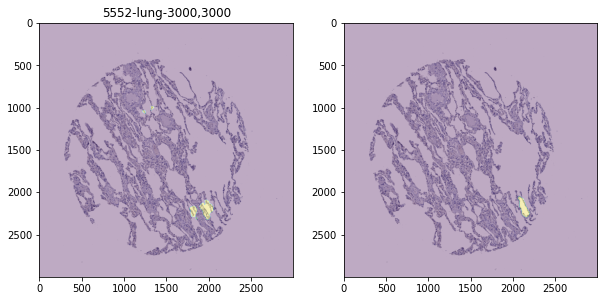

0.0 0.0


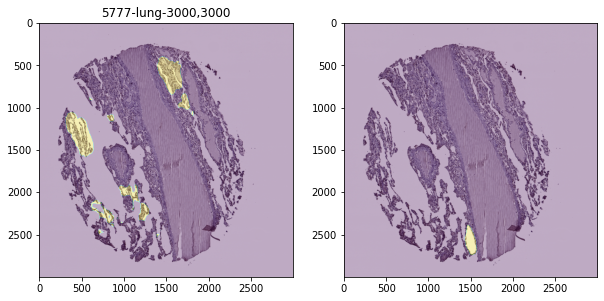

0.0 0.0


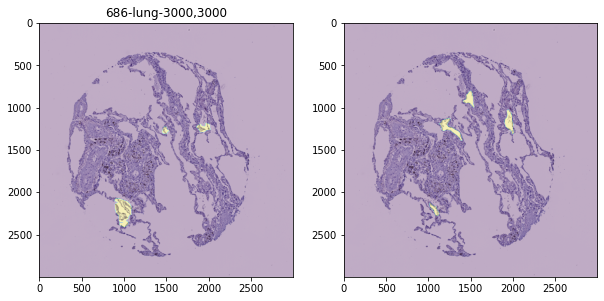

0.1756864144272717 0.0585621381424239


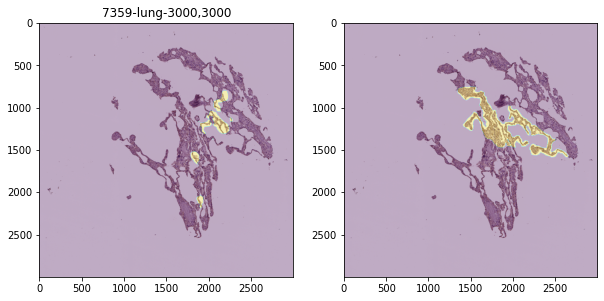

0.18888000573715846 0.09114160504110755


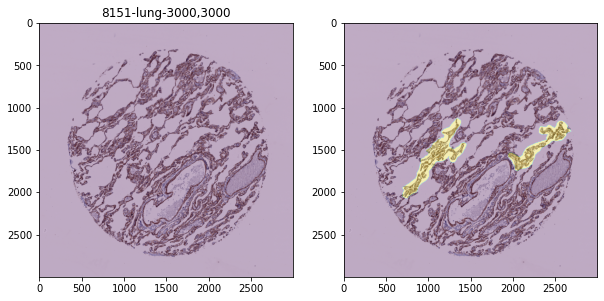

0.0 0.07291328403288604


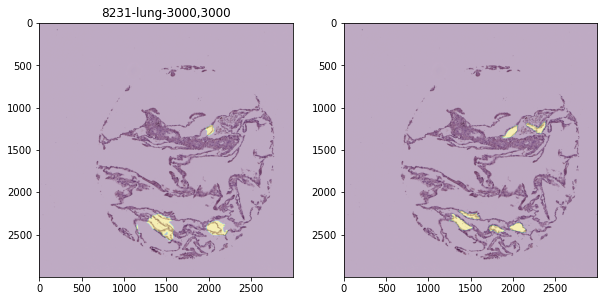

0.43803834999783575 0.13376746169371098


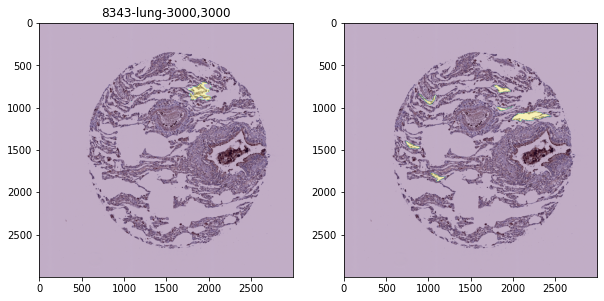

0.15165179884325067 0.1363223670007881


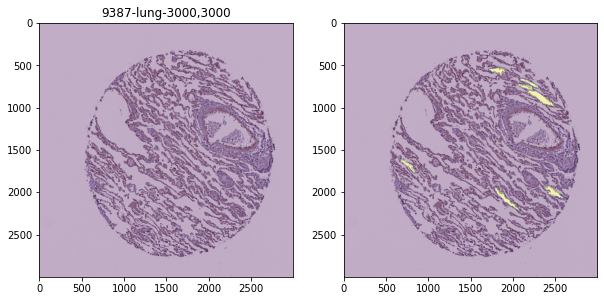

0.0 0.11928207112568957


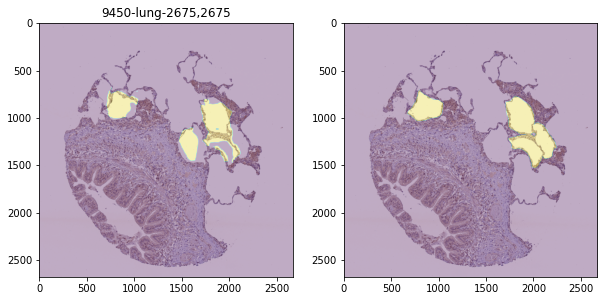

0.6646047868414579 0.17987348398299716
DICE =  0.17987348398299716


In [79]:
from PIL import Image
from transformers import SegformerFeatureExtractor
feature_extractor = SegformerFeatureExtractor(reduce_labels=False, size=(WIDTH, HEIGHT))

# print(pixel_values.shape)
# image = Image.open('/content/hubmap/train_images/10651.tiff')
# plt.imshow(image)

model2.eval()
dice = 0.0

test_df = df[df['fold'] == FOLD].reset_index()
for i in range(len(test_df)) :
  id = test_df.id[i]
  fname = "/content/hubmap/train_images/{}.tiff".format(id)
  image = Image.open(fname)
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.cuda()
  organ = test_df.organ[i]
  rle = test_df.rle[i]
  height, width = test_df.img_height[i], test_df.img_width[i]
  idx = class2idx[organ]
  with torch.no_grad():
    outputs = model2(pixel_values=pixel_values)
    upsampled_logits = nn.functional.interpolate(outputs['logits'],
                # size=image.size[::-1], # (height, width)
                (height, width),
                mode='bilinear',
                align_corners=False)
    mask = upsampled_logits.argmax(dim=1)[0]
    mask[mask != idx] = 0
    mask[mask == idx] = 1

  gt = rle2mask(rle, shape = (height, width))
  plt.figure(figsize=(10,10))
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.imshow(mask.cpu().numpy(), alpha=0.3)
  plt.title("{}-{}-{},{}".format(id, organ, width, height))
  plt.subplot(1, 2, 2)
  plt.imshow(image)
  plt.imshow(gt, alpha=0.3)
  plt.show()

  dice += dice_coef(mask.cpu().numpy(), gt)
  print(dice_coef(mask.cpu().numpy(), gt), dice/(i+1))

print("DICE = ", dice/len(test_df))

In [ ]:
len(test_df)

In [ ]:
def calc_resize(w, p) :
    a = 3000/512
    target = int((w*p/0.4)/a + 0.5)
    target = (target+31)//32 * 32
    return target

calc_resize(2023, 0.4945), calc_resize(3000, 0.4), calc_resize(160, 6.263), calc_resize(4500, 0.2290)

In [ ]:
!pip install staintools
!pip install spams

In [ ]:
# 多くのカグラーは染色ツールを使用して、増強のために組織画像の色を着色しています。
# 彼らは他のより重要な側面を見逃しています：テクスチャ（すなわち形態）
import staintools

# Read data
to_augment = staintools.read_image("/content/hubmap/train_images/10044.tiff")

# Standardize brightness (optional, can improve the tissue mask calculation)
# to_augment = staintools.LuminosityStandardizer.standardize(to_augment)

# Stain augment
augmentor = staintools.StainAugmentor(method='vahadane', sigma1=0.2, sigma2=0.2)

augmentor.fit(to_augment)
augmented_images = []
for _ in range(2):
    augmented_image = augmentor.pop()
    augmented_images.append(augmented_image)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(to_augment)
plt.show()
for e in augmented_images:
  plt.imshow(e/255)
  plt.show()